# The IQ-OTH/NCCD lung cancer dataset
## Lung Cancer CT Scans from Iraqi hospitals: Normal, Benign, and Malignant Cases

## About Dataset
The Iraq-Oncology Teaching Hospital/National Center for Cancer Diseases (IQ-OTH/NCCD) lung cancer dataset was collected in the above-mentioned specialist hospitals over a period of three months in fall 2019. It includes CT scans of patients diagnosed with lung cancer in different stages, as well as healthy subjects. IQ-OTH/NCCD slides were marked by oncologists and radiologists in these two centers. The dataset contains a total of 1190 images representing CT scan slices of 110 cases. These cases are grouped into three classes: normal, benign, and malignant. of these, 40 cases are diagnosed as malignant; 15 cases diagnosed with benign; and 55 cases classified as normal cases. The CT scans were originally collected in DICOM format. The scanner used is SOMATOM from Siemens. CT protocol includes: 120 kV, slice thickness of 1 mm, with window width ranging from 350 to 1200 HU and window center from 50 to 600 were used for reading. with breath hold at full inspiration. All images were de-identified before performing analysis. Written consent was waived by the oversight review board. The study was approved by the institutional review board of participating medical centers. Each scan contains several slices. The number of these slices range from 80 to 200 slices, each of them represents an image of the human chest with different sides and angles. The 110 cases vary in gender, age, educational attainment, area of residence and living status. Some of them are employees of the Iraqi ministries of Transport and Oil, others are farmers and gainers. Most of them come from places in the middle region of Iraq, particularly, the provinces of Baghdad, Wasit, Diyala, Salahuddin, and Babylon.

if you use this dataset you should cite the following articles:

1- Diagnosis of lung cancer based on CT scans using CNN
can be cited as :
(H. F. Al-Yasriy, M. S. Al-Husieny, F. Y. Mohsen, E. A. Khalil, and Z. S. Hassan, "Diagnosis of Lung Cancer Based on CT Scans Using CNN," IOP Conference Series: Materials Science and Engineering, vol. 928, 2020.)

2- Evaluation of SVM performance in the detection of lung cancer in marked CT scan dataset
can be cited as:
(H. F. Kareem, M. S. A.-Husieny, F. Y. Mohsen, E. A. Khalil, and Z. S. Hassan, “Evaluation of SVM performance in the detection
of lung cancer in marked CT scan dataset,” Indonesian Journal of Electrical Engineering and Computer Science, vol. 21, no. 3,
pp. 1731-1738, 2021, doi: 10.11591/ijeecs.v21.i3.pp1731-1738.)

3- The IQ-OTH/NCCD lung cancer dataset
can be cited as :
(alyasriy, hamdalla; AL-Huseiny, Muayed (2023), “The IQ-OTH/NCCD lung cancer dataset”, Mendeley Data, V4, doi: 10.17632/bhmdr45bh2.4)

# Import Libraries

In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import seaborn as sns
import random
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn import metrics

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours, NearMiss
from imblearn.combine import SMOTEENN

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications import ResNet50V2, EfficientNetV2B0
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from keras.regularizers import l2
import keras_tuner as kt

from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

num_classes=3

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./logs')
pd.set_option('display.max_colwidth', None)

ImportError: cannot import name 'kt' from 'keras_tuner' (C:\Users\ivans\anaconda3\Lib\site-packages\keras_tuner\__init__.py)

In [2]:
directory = r"lung_cancer_dataset"
categories = ["Bengin cases", "Malignant cases", "Normal cases"]

benign_directory = directory + "/" + categories[0]
malignant_directory = directory + "/" + categories[1]
normal_directory = directory + "/" + categories[2]

# saving the path of all data in dictionary
path_list = []
category_list = []
for category in categories:
    folder_path = os.path.join(directory, category)
    folder_image_contents = os.listdir(folder_path)
    for image_file in folder_image_contents:
        image_file_path = os.path.join(folder_path, image_file)
        path_list.append(image_file_path)
        category_list.append(category)

path_series = pd.Series(path_list, name="filepath")
category_series = pd.Series(category_list, name="category")

image_paths_df = pd.DataFrame(path_series).join(category_series)

#image_paths_df.head()        

# Image resizing

In [99]:
# read image size and put it into dataframe
size_data = {}
is_grayscale = 0 # enter 0 for color, 1 for grayscale
for category in categories:
    folder_path = os.path.join(directory, category)
    folder_image_contents = os.listdir(folder_path)
    image_sizes_in_one_category = {}
    for image_file in folder_image_contents:
        image_file_path = os.path.join(folder_path, image_file)
        img = cv2.imread(image_file_path)
        height, width, channel = img.shape
        if(str(height) + " x " + str(width) in image_sizes_in_one_category):
            image_sizes_in_one_category[str(height) + " x " + str(width)] += 1
        else:
            image_sizes_in_one_category[str(height) + " x " + str(width)] = 1
    #plt.imshow(cv2.imread(image_file_path, is_grayscale))
    #plt.show()
    size_data[category] = image_sizes_in_one_category
size_data_df = pd.DataFrame(size_data)
#print(size_data)
size_data_df.head(10)

Bengin cases  Malignant cases  Normal cases
512 x 512         120.0            501.0         415.0
404 x 511           NaN              1.0           NaN
512 x 801           NaN             28.0           NaN
512 x 623           NaN             31.0           NaN
331 x 506           NaN              NaN           1.0

In [5]:
dataset = []
desired_size = 256
for index, row in image_paths_df.iterrows():
    filepath = row["filepath"]
    img = cv2.imread(filepath, is_grayscale)
    img = cv2.resize(img, (desired_size, desired_size))
    label = row["category"]
    dataset.append([img, label])
    
random.shuffle(dataset)

#print(dataset[0][1])
#plt.imshow(dataset[0][0])
#plt.show()

# Image smoothing

In [7]:
# using gaussian blur
#kernel_shape = 3
#for data in dataset:
#    img = cv2.GaussianBlur(data[0], (kernel_shape, kernel_shape), 0)
#    data[0] = img

#plt.imshow(dataset[0][0])
#plt.show()

In [8]:
# using bilateral filtering
diameter = 3
sigma_color = 25
sigma_space = 25
for data in dataset:
    img = cv2.bilateralFilter(data[0], diameter, sigma_color, sigma_space)
    data[0] = img

#plt.imshow(dataset[0][0])
#plt.show()

In [9]:
# using 2d convolution
#kernel_size = 5
#kernel_ = np.ones((kernel_size, kernel_size), np.float32)/(kernel_size*kernel_size)
#for data in dataset:
#    img = cv2.filter2D(src=data[0], ddepth=-1, kernel=kernel_)
#    data[0] = img

#plt.imshow(dataset[0][0])
#plt.show()

# Data normalization

In [11]:
# using min-max scaling
for data in dataset:
    img = data[0]/255.0
    data[0] = img

#plt.imshow(dataset[0][0])
#plt.show()

In [12]:
# using standardization
#for data in dataset:
#    mean, std = cv2.meanStdDev(data[0])
#    img = (data[0] - mean) / std
#    data[0] = img

#plt.imshow(dataset[0][0])
#plt.show()

# Data splitting

In [14]:
x, y = [], []
for image, category in dataset:
    x.append(image)
    y.append(category)

x = np.array(x)
y = np.array(y)

x, x_test, y, y_test = train_test_split(x, y, test_size = 0.2, random_state = 15, stratify=y)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.33, random_state = 15, stratify=y)

label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

# apply one-hot encoding

y_val = to_categorical(y_val, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

y_test_labels = np.argmax(y_test, axis=1)

for i in range(0, len(label_encoder.classes_)):
    print(i, end="")
    print(" = ", end="")
    print(label_encoder.classes_[i])

0 = Bengin cases
1 = Malignant cases
2 = Normal cases


# Handling data imbalance

In [16]:
# using SMOTE (like example)
print(x_train.shape)
number_of_samples = x_train.shape[0]
x_train = x_train.reshape(number_of_samples, -1)
print(x_train.shape)

print("before: ", Counter(y_train))

sample_nums = max(Counter(y_train).values()) * 2
sampling_strategy = {1: sample_nums, 2: sample_nums, 0: sample_nums}

x_train_smt, y_train_smt = SMOTE(sampling_strategy=sampling_strategy, random_state=42).fit_resample(x_train, y_train)

print("after: ", Counter(y_train_smt))
x_train = x_train.reshape(number_of_samples, desired_size, desired_size, 1)
x_train_smt = x_train_smt.reshape(x_train_smt.shape[0], desired_size, desired_size, 1)
print(x_train.shape)
print(x_train_smt.shape)

y_train_smt = to_categorical(y_train_smt, num_classes=3)


x_train_smt = np.repeat(x_train_smt, 3, axis=-1)
x_val = np.expand_dims(x_val, axis=-1)
x_val = np.repeat(x_val, 3, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)
x_test = np.repeat(x_test, 3, axis=-1)

(587, 256, 256)
(587, 65536)
before:  Counter({1: 300, 2: 223, 0: 64})
after:  Counter({1: 600, 2: 600, 0: 600})
(587, 256, 256, 1)
(1800, 256, 256, 1)


In [28]:
number_of_samples = x_train.shape[0]
x_train = x_train.reshape(number_of_samples, -1)

# Initialize SMOTE and ENN
smote_enn = SMOTEENN(sampling_strategy='auto', random_state=42)

# Apply SMOTEENN to resample the training data
x_train_hybrid, y_train_hybrid = smote_enn.fit_resample(x_train, y_train)

x_train = x_train.reshape(number_of_samples, desired_size, desired_size, 1)
x_train_hybrid = x_train_hybrid.reshape(x_train_hybrid.shape[0], desired_size, desired_size, 1)

y_train_hybrid = to_categorical(y_train_hybrid, num_classes=3)

# Check the new class distribution
print("After Hybrid Resampling:")
print(f"Counts of label '0': {np.sum(y_train_hybrid[:, 0])}")
print(f"Counts of label '1': {np.sum(y_train_hybrid[:, 1])}")
print(f"Counts of label '2': {np.sum(y_train_hybrid[:, 2])}")

After Hybrid Resampling:
Counts of label '0': 296.0
Counts of label '1': 280.0
Counts of label '2': 277.0


In [44]:
# using near miss algorithm -> don't use, result is bad
print("Before Undersampling, counts of label '2': {}".format(sum(y_train == 2)))
print("Before Undersampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before Undersampling, counts of label '0': {} \n".format(sum(y_train == 0)))

number_of_samples = x_train.shape[0]
x_train = x_train.reshape(number_of_samples, -1)

nr = NearMiss()

x_train_miss, y_train_miss = nr.fit_resample(x_train, y_train.ravel())

x_train = x_train.reshape(number_of_samples, desired_size, desired_size, 1)
x_train_miss = x_train_miss.reshape(x_train_miss.shape[0], desired_size, desired_size, 1)

y_train_miss = to_categorical(y_train_miss, num_classes=3)

print('After Undersampling, the shape of train_x: {}'.format(x_train_miss.shape))
print('After Undersampling, the shape of train_y: {} \n'.format(y_train_miss.shape))

print("After Undersampling, counts of label '2': {}".format(np.sum(y_train_miss[:, 2])))
print("After Undersampling, counts of label '1': {}".format(np.sum(y_train_miss[:, 1])))
print("After Undersampling, counts of label '0': {}".format(np.sum(y_train_miss[:, 0])))

Before Undersampling, counts of label '2': 223
Before Undersampling, counts of label '1': 300
Before Undersampling, counts of label '0': 64 

After Undersampling, the shape of train_x: (192, 256, 256, 1)
After Undersampling, the shape of train_y: (192, 3) 

After Undersampling, counts of label '2': 64.0
After Undersampling, counts of label '1': 64.0
After Undersampling, counts of label '0': 64.0


# Data models

In [27]:
def all_evaluation(y_test_labels, y_pred_labels, model, epoch_num, batch, is_tuning=False):
    output_path = 'output\\' + model + '_epoch' + str(epoch_num) + '_batch' + str(batch)
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    # Accuracy, precision, recall, f1 score
    print(metrics.classification_report(y_test_labels, y_pred_labels, digits=4))
    report = metrics.classification_report(y_test_labels, y_pred_labels, digits=4)
    cm = metrics.confusion_matrix(y_test_labels, y_pred_labels)
    
    print(f"The Cohen's Kappa Score is: {metrics.cohen_kappa_score(y_test_labels, y_pred_labels)}")
    cohen = metrics.cohen_kappa_score(y_test_labels, y_pred_labels)
    with open(output_path + '\\evaluation_report.txt', 'w') as f:
        f.write(report)
        f.write('\n')
        f.write('The Cohen\'s Kappa Score is: ' + str(cohen))
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Bengin', 'Malignant', 'Normal'],
                yticklabels=['Bengin', 'Malignant', 'Normal'])
    plt.xlabel("Predicted Labels", fontsize=14)
    plt.ylabel("True Labels", fontsize=14)
    plt.savefig(output_path + '\\confusion_matrix.jpg')
    plt.show()

### Using CNN

C:\Users\ivans\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 128)  │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    14,745,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,969,283 (57.10 MB)

 Trainable params: 14,969,283 (57.10 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
113/113 ━━━━━━━━━━━━━━━━━━━━ 239s 2s/step - accuracy: 0.5104 - loss: 0.9772 - val_accuracy: 0.9345 - val_loss: 0.2472 - learning_rate: 0.0010
Epoch 2/25
113/113 ━━━━━━━━━━━━━━━━━━━━ 234s 2s/step - accuracy: 0.9588 - loss: 0.1222 - val_accuracy: 0.9310 - val_loss: 0.2932 - learning_rate: 0.0010
Epoch 3/25
113/113 ━━━━━━━━━━━━━━━━━━━━ 234s 2s/step - accuracy: 0.9821 - loss: 0.0650 - val_accuracy: 0.9552 - val_loss: 0.1814 - learning_rate: 0.0010
Epoch 4/25
113/113 ━━━━━━━━━━━━━━━━━━━━ 235s 2s/step - accuracy: 0.9864 - loss: 0.0383 - val_accuracy: 0.9586 - val_loss: 0.1969 - learning_rate: 0.0010
Epoch 5/25
113/113 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.9908 - loss: 0.0298 - val_accuracy: 0.9621 - val_loss: 0.2520 - learning_rate: 0.0010
Epoch 6/25
113/113 ━━━━━━━━━━━━━━━━━━━━ 233s 2s/step - accuracy: 0.9908 - loss: 0.0515 - val_accuracy: 0.9690 - val_loss: 0.2239 - learning_rate: 0.0010
Epoch 7/25
113/113 ━━━━━━━━━━━━━━━━━━━━ 235s 2s/step - accuracy: 0.9920 - loss: 0.

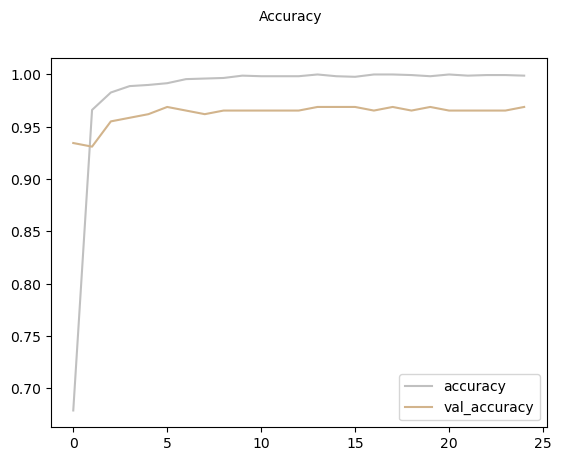

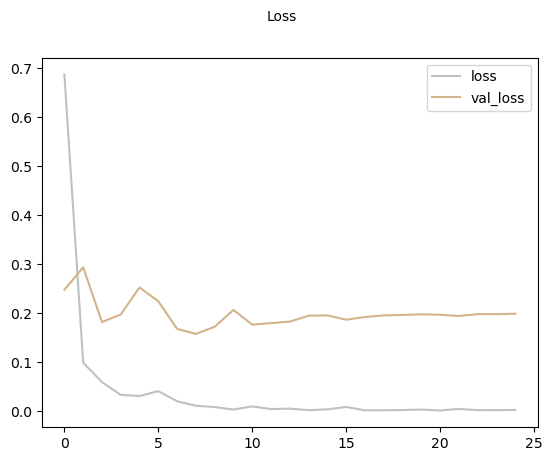

7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 912ms/step
              precision    recall  f1-score   support

           0     0.9565    0.9167    0.9362        24
           1     0.9912    0.9912    0.9912       113
           2     0.9762    0.9880    0.9820        83

    accuracy                         0.9818       220
   macro avg     0.9746    0.9653    0.9698       220
weighted avg     0.9817    0.9818    0.9817       220

The Cohen's Kappa Score is: 0.9686910733980859


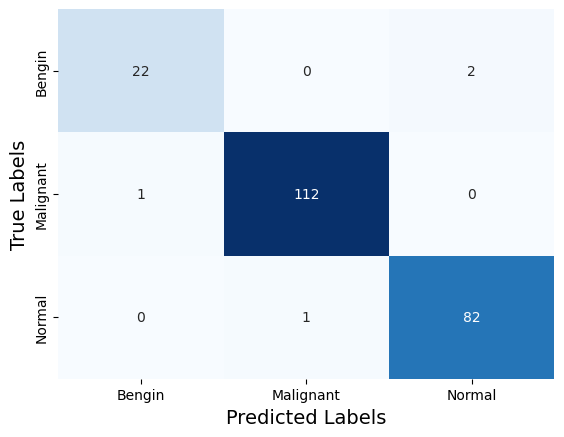

CPU times: total: 11h 17min 45s
Wall time: 1h 38min 50s


In [22]:
%%time

model_name = 'cnn'
epoch_num = 25
batch = 16

# cnn model
def build_model_cnn(optimizer="adam", dropout_rate=0.5):
    model = Sequential()
    model.add(Conv2D(128, (3, 3), activation="relu", input_shape=(x_train_smt.shape[1:])))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(128, (3, 3), activation="relu"))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(64, (3, 3), activation="relu"))
    model.add(MaxPooling2D(2, 2))
    model.add(Flatten())
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(optimizer=optimizer, 
                  loss=tf.keras.losses.CategoricalCrossentropy(), 
                  metrics=["accuracy"])
    return model

model_cnn = build_model_cnn()
model_cnn.summary()

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

history_cnn = model_cnn.fit(x_train_smt, y_train_smt, batch_size = batch, epochs = epoch_num, validation_data = (x_val, y_val), callbacks=[lr_reducer, tensorboard_callback])

fig = plt.figure()
plt.plot(history_cnn.history['accuracy'], color='silver', label='accuracy')
plt.plot(history_cnn.history['val_accuracy'], color='tan', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=10)
plt.legend(loc="lower right")
plt.show()

fig = plt.figure()
plt.plot(history_cnn.history['loss'], color='silver', label='loss')
plt.plot(history_cnn.history['val_loss'], color='tan', label='val_loss')
fig.suptitle('Loss', fontsize=10)
plt.legend(loc="upper right")
plt.show()

y_pred = model_cnn.predict(x_test)

y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

all_evaluation(y_test_labels, y_pred_labels, model_name, epoch_num, batch)

### Using ResNet 50 V2

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, None,      │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │      9,472 │ conv1_pad[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, None,      │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, None,      │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, None,      │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, None,      │          0 │ conv2_block1_pre… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, None,      │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, None,      │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, None,      │          0 │ conv2_block1_1_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, None,      │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, None,      │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, None,      │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, None,      │          0 │ conv2_block1_2_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, None,      │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, None,      │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, None,      │          0 │ conv2_block1_0_c

 Total params: 25,670,147 (97.92 MB)

 Trainable params: 5,519,363 (21.05 MB)

 Non-trainable params: 20,150,784 (76.87 MB)

Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 135s 4s/step - accuracy: 0.7879 - loss: 0.6753 - val_accuracy: 0.8862 - val_loss: 0.2757 - learning_rate: 0.0010
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 124s 4s/step - accuracy: 0.9837 - loss: 0.0454 - val_accuracy: 0.8586 - val_loss: 0.5308 - learning_rate: 0.0010
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 126s 4s/step - accuracy: 0.9989 - loss: 0.0048 - val_accuracy: 0.9586 - val_loss: 0.1275 - learning_rate: 0.0010
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 126s 4s/step - accuracy: 0.9995 - loss: 0.0021 - val_accuracy: 0.9655 - val_loss: 0.1303 - learning_rate: 0.0010
Epoch 5/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 125s 4s/step - accuracy: 0.9988 - loss: 0.0029 - val_accuracy: 0.9655 - val_loss: 0.1269 - learning_rate: 0.0010
Epoch 6/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 144s 4s/step - accuracy: 1.0000 - loss: 8.3539e-04 - val_accuracy: 0.9517 - val_loss: 0.1473 - learning_rate: 0.0010
Epoch 7/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 125s 4s/step - accuracy: 1.0000 - loss: 8.4978e-04 -

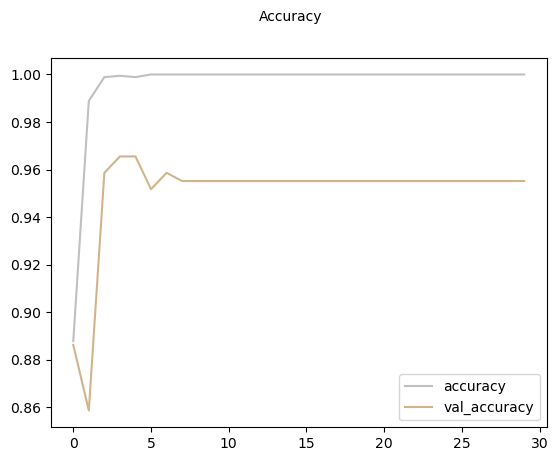

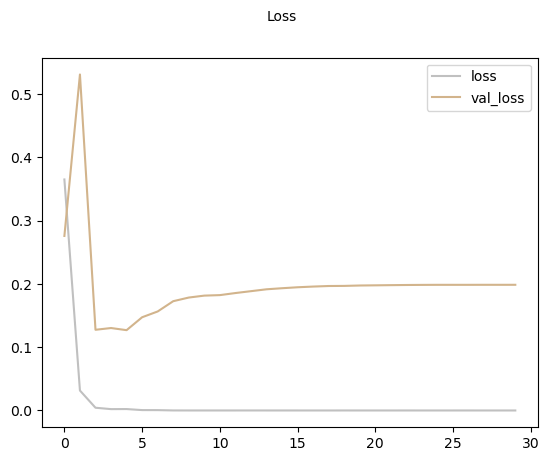

7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step
              precision    recall  f1-score   support

           0     1.0000    0.7083    0.8293        24
           1     1.0000    1.0000    1.0000       113
           2     0.9222    1.0000    0.9595        83

    accuracy                         0.9682       220
   macro avg     0.9741    0.9028    0.9296       220
weighted avg     0.9707    0.9682    0.9661       220

The Cohen's Kappa Score is: 0.9445105033690051


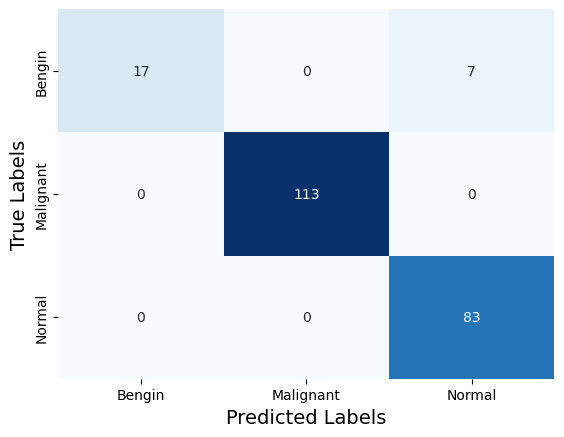

CPU times: total: 4h 15min 34s
Wall time: 1h 4min 6s


In [31]:
%%time
model_name = 'resnet50v2'
epoch_num = 30
batch = 64
num_classes = 3

#x_train_smt = np.repeat(x_train_smt, 3, axis=-1)
#x_val = np.expand_dims(x_val, axis=-1)
#x_val = np.repeat(x_val, 3, axis=-1)
#x_test = np.expand_dims(x_test, axis=-1)
#x_test = np.repeat(x_test, 3, axis=-1)

def build_model_ResNet50V2():
    base_model = ResNet50V2(weights='imagenet', include_top=False)
    base_model.trainable = True
    for layer in base_model.layers[:-10]:  
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model_resnet50v2 = build_model_ResNet50V2()
model_resnet50v2.summary()

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

history_resnet50v2 = model_resnet50v2.fit(x_train_smt, y_train_smt, batch_size = batch, epochs = epoch_num, validation_data = (x_val, y_val), callbacks=[lr_reducer, tensorboard_callback])

fig = plt.figure()
plt.plot(history_resnet50v2.history['accuracy'], color='silver', label='accuracy')
plt.plot(history_resnet50v2.history['val_accuracy'], color='tan', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=10)
plt.legend(loc="lower right")
plt.show()

fig = plt.figure()
plt.plot(history_resnet50v2.history['loss'], color='silver', label='loss')
plt.plot(history_resnet50v2.history['val_loss'], color='tan', label='val_loss')
fig.suptitle('Loss', fontsize=10)
plt.legend(loc="upper right")
plt.show()

y_pred = model_resnet50v2.predict(x_test)

y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

all_evaluation(y_test_labels, y_pred_labels, model_name, epoch_num, batch)

### Using NasNetMobile

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv1 (Conv2D) │ (None, 111, 111,  │        864 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn1            │ (None, 111, 111,  │        128 │ stem_conv1[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_203      │ (None, 111, 111,  │          0 │ stem_bn1[0][0]    │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reduction_conv_1_s… │ (None, 111, 111,  │        352 │ activation_203[0… │
│ (Conv2D)            │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reduction_bn_1_ste… │ (None, 111, 111,  │         44 │ reduction_conv_1… │
│ (BatchNormalizatio… │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_204      │ (None, 111, 111,  │          0 │ reduction_bn_1_s… │
│ (Activation)        │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_206      │ (None, 111, 111,  │          0 │ stem_bn1[0][0]    │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_p… │ (None, 115, 115,  │          0 │ activation_204[0… │
│ (ZeroPadding2D)     │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_p… │ (None, 117, 117,  │          0 │ activation_206[0… │
│ (ZeroPadding2D)     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_r… │ (None, 56, 56,    │        396 │ separable_conv_1… │
│ (SeparableConv2D)   │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_r… │ (None, 56, 56,    │      1,920 │ separable_conv_1… │
│ (SeparableConv2D)   │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_b… │ (None, 56, 56,    │         44 │ separable_conv_1… │
│ (BatchNormalizatio… │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_b… │ (None, 56, 56,    │         44 │ separable_conv_1… │
│ (BatchNormalizatio… │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_205      │ (None, 56, 56,    │          0 │ separable_conv_1… │
│ (Activation)        │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_207      │ (None, 56, 56,    │          0 │ separable_conv_1… │
│ (Activation)        │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_2_r… │ (None, 56, 56,    │        396 │ activation_205[0

 Total params: 5,359,255 (20.44 MB)

 Trainable params: 1,087,843 (4.15 MB)

 Non-trainable params: 4,271,412 (16.29 MB)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 60s 635ms/step - accuracy: 0.6864 - loss: 0.9406 - val_accuracy: 0.8276 - val_loss: 0.4317 - learning_rate: 0.0010
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 28s 492ms/step - accuracy: 0.9109 - loss: 0.2541 - val_accuracy: 0.8621 - val_loss: 0.3669 - learning_rate: 0.0010
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 29s 504ms/step - accuracy: 0.9410 - loss: 0.1662 - val_accuracy: 0.8966 - val_loss: 0.2898 - learning_rate: 0.0010
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 30s 532ms/step - accuracy: 0.9632 - loss: 0.1013 - val_accuracy: 0.9034 - val_loss: 0.2894 - learning_rate: 0.0010
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 31s 544ms/step - accuracy: 0.9761 - loss: 0.0842 - val_accuracy: 0.8897 - val_loss: 0.3947 - learning_rate: 0.0010
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 29s 517ms/step - accuracy: 0.9641 - loss: 0.0980 - val_accuracy: 0.9172 - val_loss: 0.2952 - learning_rate: 0.0010
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 30s 518ms/step - accuracy: 0.9794 - loss: 0.

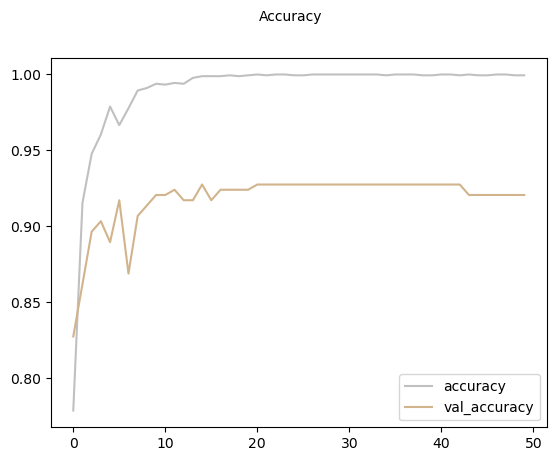

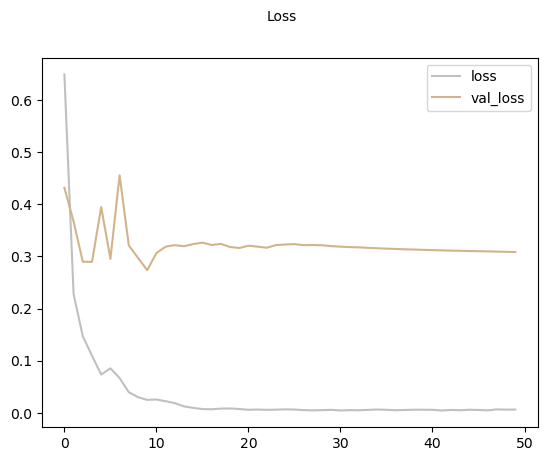

7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step 
              precision    recall  f1-score   support

           0     0.8125    0.5417    0.6500        24
           1     0.9818    0.9558    0.9686       113
           2     0.8511    0.9639    0.9040        83

    accuracy                         0.9136       220
   macro avg     0.8818    0.8204    0.8409       220
weighted avg     0.9140    0.9136    0.9095       220

The Cohen's Kappa Score is: 0.8495536999712064


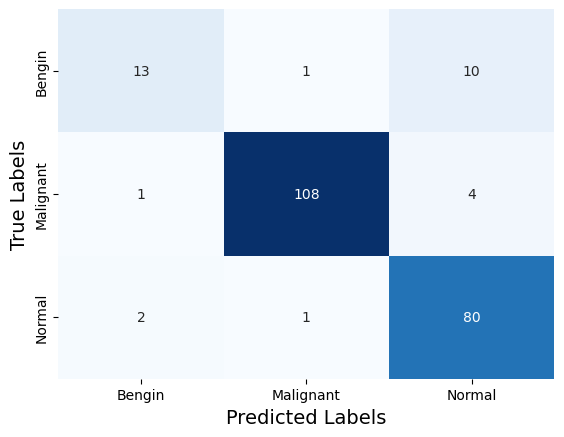

CPU times: total: 1h 11min 33s
Wall time: 24min


In [34]:
%%time
from tensorflow.keras.applications import NASNetMobile

model_name = 'nasnetmobile'
epoch_num = 50
batch = 32
num_classes = 3

#x_train_smt = np.repeat(x_train_smt, 3, axis=-1)
#x_val = np.expand_dims(x_val, axis=-1)
#x_val = np.repeat(x_val, 3, axis=-1)
#x_test = np.expand_dims(x_test, axis=-1)
#x_test = np.repeat(x_test, 3, axis=-1)

x_train_smt = tf.image.resize(x_train_smt, (224, 224)).numpy()
x_val = tf.image.resize(x_val, (224, 224)).numpy()
x_test = tf.image.resize(x_test, (224, 224)).numpy()


def build_model_nasnetmobile():
    base_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = True
    for layer in base_model.layers[:-10]:  
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model_nasnetmobile = build_model_nasnetmobile()
model_nasnetmobile.summary()

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

history_nasnetmobile = model_nasnetmobile.fit(x_train_smt, y_train_smt, batch_size = batch, epochs = epoch_num, validation_data = (x_val, y_val), callbacks=[lr_reducer, tensorboard_callback])

fig = plt.figure()
plt.plot(history_nasnetmobile.history['accuracy'], color='silver', label='accuracy')
plt.plot(history_nasnetmobile.history['val_accuracy'], color='tan', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=10)
plt.legend(loc="lower right")
plt.show()

fig = plt.figure()
plt.plot(history_nasnetmobile.history['loss'], color='silver', label='loss')
plt.plot(history_nasnetmobile.history['val_loss'], color='tan', label='val_loss')
fig.suptitle('Loss', fontsize=10)
plt.legend(loc="upper right")
plt.show()

y_pred = model_nasnetmobile.predict(x_test)

y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

all_evaluation(y_test_labels, y_pred_labels, model_name, epoch_num, batch)

### MobileNetV2

Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_26      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_26[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,576,899 (13.64 MB)

 Trainable params: 2,049,347 (7.82 MB)

 Non-trainable params: 1,527,552 (5.83 MB)

Epoch 1/40
113/113 ━━━━━━━━━━━━━━━━━━━━ 28s 212ms/step - accuracy: 0.7484 - loss: 0.7361 - val_accuracy: 0.1483 - val_loss: 12.6689 - learning_rate: 0.0010
Epoch 2/40
113/113 ━━━━━━━━━━━━━━━━━━━━ 23s 200ms/step - accuracy: 0.9389 - loss: 0.1736 - val_accuracy: 0.4379 - val_loss: 8.3877 - learning_rate: 0.0010
Epoch 3/40
113/113 ━━━━━━━━━━━━━━━━━━━━ 22s 190ms/step - accuracy: 0.9674 - loss: 0.1051 - val_accuracy: 0.2931 - val_loss: 10.3160 - learning_rate: 0.0010
Epoch 4/40
113/113 ━━━━━━━━━━━━━━━━━━━━ 22s 192ms/step - accuracy: 0.9777 - loss: 0.0583 - val_accuracy: 0.6586 - val_loss: 2.6551 - learning_rate: 0.0010
Epoch 5/40
113/113 ━━━━━━━━━━━━━━━━━━━━ 21s 190ms/step - accuracy: 0.9801 - loss: 0.0645 - val_accuracy: 0.7069 - val_loss: 5.2216 - learning_rate: 0.0010
Epoch 6/40
113/113 ━━━━━━━━━━━━━━━━━━━━ 22s 193ms/step - accuracy: 0.9810 - loss: 0.0428 - val_accuracy: 0.9207 - val_loss: 0.3499 - learning_rate: 0.0010
Epoch 7/40
113/113 ━━━━━━━━━━━━━━━━━━━━ 22s 192ms/step - accuracy: 0

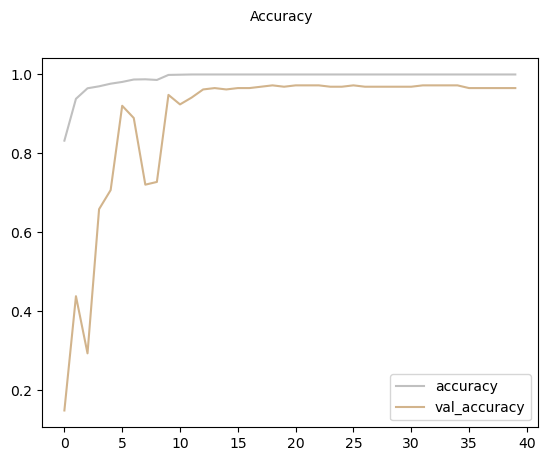

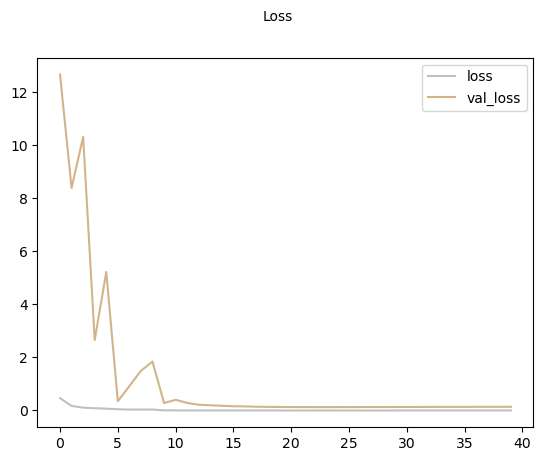

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 365ms/step
              precision    recall  f1-score   support

           0     0.9500    0.7917    0.8636        24
           1     0.9912    1.0000    0.9956       113
           2     0.9419    0.9759    0.9586        83

    accuracy                         0.9682       220
   macro avg     0.9610    0.9225    0.9393       220
weighted avg     0.9681    0.9682    0.9672       220

The Cohen's Kappa Score is: 0.9448028673835125


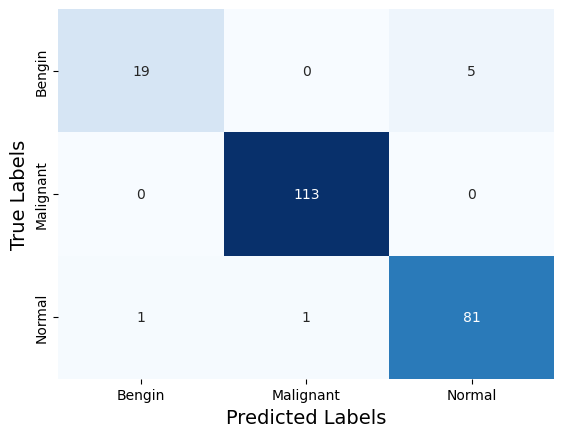

CPU times: total: 4min 34s
Wall time: 14min 47s


In [88]:
%%time
from tensorflow.keras.applications import MobileNetV2

#15 or 25
model_name = 'mobilenetv2'
epoch_num = 40
batch = 16
num_classes = 3

#x_train_smt = np.repeat(x_train_smt, 3, axis=-1)
#x_val = np.expand_dims(x_val, axis=-1)
#x_val = np.repeat(x_val, 3, axis=-1)
#x_test = np.expand_dims(x_test, axis=-1)
#x_test = np.repeat(x_test, 3, axis=-1)

x_train_smt = tf.image.resize(x_train_smt, (224, 224)).numpy()
x_val = tf.image.resize(x_val, (224, 224)).numpy()
x_test = tf.image.resize(x_test, (224, 224)).numpy()


def build_model_mobilenetv2():
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = True
    for layer in base_model.layers[:-10]:  
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model_mobilenetv2 = build_model_mobilenetv2()
model_mobilenetv2.summary()

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

history_mobilenetv2 = model_mobilenetv2.fit(x_train_smt, y_train_smt, batch_size = batch, epochs = epoch_num, validation_data = (x_val, y_val), callbacks=[lr_reducer, tensorboard_callback])

fig = plt.figure()
plt.plot(history_mobilenetv2.history['accuracy'], color='silver', label='accuracy')
plt.plot(history_mobilenetv2.history['val_accuracy'], color='tan', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=10)
plt.legend(loc="lower right")
plt.show()

fig = plt.figure()
plt.plot(history_mobilenetv2.history['loss'], color='silver', label='loss')
plt.plot(history_mobilenetv2.history['val_loss'], color='tan', label='val_loss')
fig.suptitle('Loss', fontsize=10)
plt.legend(loc="upper right")
plt.show()

y_pred = model_mobilenetv2.predict(x_test)

y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

all_evaluation(y_test_labels, y_pred_labels, model_name, epoch_num, batch)

### EfficientNetV2 variations

#### EfficientNetV2B0

Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_22      │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, None,      │        864 │ input_layer_22[0… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, None,      │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, None,      │          0 │ stem_bn[0][0]     │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, None,      │      4,608 │ stem_activation[… │
│ (Conv2D)            │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, None,      │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, None,      │          0 │ block1a_project_… │
│ (Activation)        │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, None,      │      9,216 │ block1a_project_… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, None,      │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, None,      │          0 │ block2a_expand_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, None,      │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, None,      │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, None,      │     36,864 │ block2a_project_… │
│ (Conv2D)            │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, None,      │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, None,      │          0 │ block2b_expand_b… │
│ (Activation)        │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_project_co… │ (None, None,      │      4,096 │ block2b_expand_a… │
│ (Conv2D)            │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_project_bn  │ (None, None,      │        128 │ block2b_project_

 Total params: 7,238,227 (27.61 MB)

 Trainable params: 1,898,547 (7.24 MB)

 Non-trainable params: 5,339,680 (20.37 MB)

Epoch 1/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 36s 255ms/step - accuracy: 0.6453 - loss: 1.3536 - val_accuracy: 0.8862 - val_loss: 0.3570 - learning_rate: 0.0010
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 27s 239ms/step - accuracy: 0.8687 - loss: 0.3900 - val_accuracy: 0.9138 - val_loss: 0.2096 - learning_rate: 0.0010
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 28s 247ms/step - accuracy: 0.8942 - loss: 0.3165 - val_accuracy: 0.9724 - val_loss: 0.1091 - learning_rate: 0.0010
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 28s 251ms/step - accuracy: 0.9366 - loss: 0.1604 - val_accuracy: 0.9621 - val_loss: 0.1233 - learning_rate: 0.0010
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 27s 243ms/step - accuracy: 0.9422 - loss: 0.1608 - val_accuracy: 0.9552 - val_loss: 0.1383 - learning_rate: 0.0010
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 28s 251ms/step - accuracy: 0.9598 - loss: 0.1219 - val_accuracy: 0.9345 - val_loss: 0.1612 - learning_rate: 0.0010
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 27s 241ms/step - accuracy: 0.9

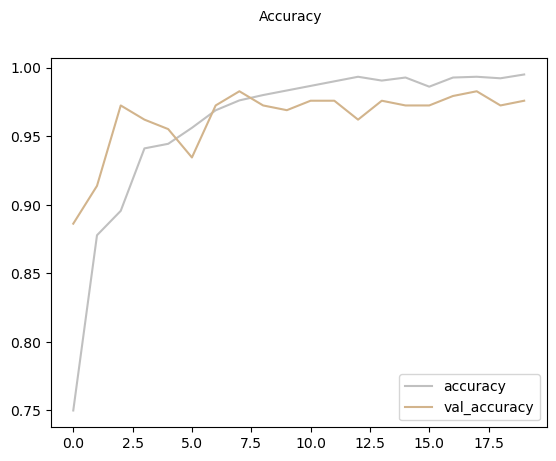

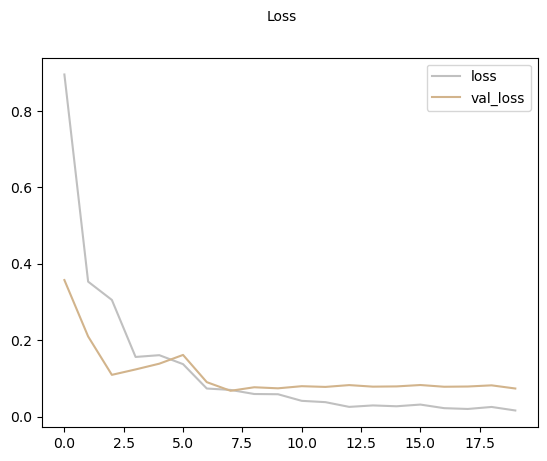

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 525ms/step
              precision    recall  f1-score   support

           0     0.9545    0.8750    0.9130        24
           1     0.9912    0.9912    0.9912       113
           2     0.9529    0.9759    0.9643        83

    accuracy                         0.9727       220
   macro avg     0.9662    0.9474    0.9562       220
weighted avg     0.9727    0.9727    0.9725       220

The Cohen's Kappa Score is: 0.952937820878494


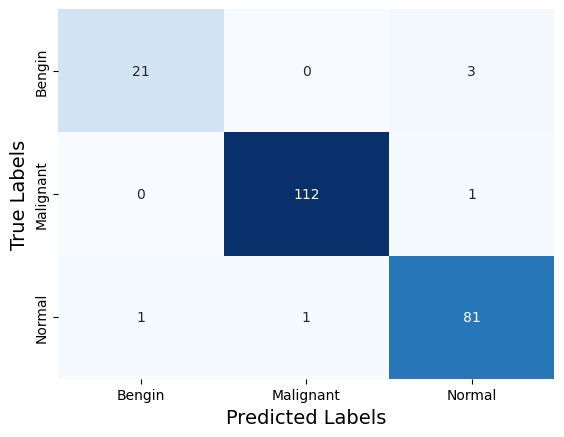

CPU times: total: 3min 20s
Wall time: 9min 29s


In [83]:
%%time

from tensorflow.keras.applications import EfficientNetV2B0

model_name = 'EfficientNetV2B0'
epoch_num = 20
batch = 16
num_classes = 3

#x_train_smt = np.repeat(x_train_smt, 3, axis=-1)
#x_val = np.expand_dims(x_val, axis=-1)
#x_val = np.repeat(x_val, 3, axis=-1)
#x_test = np.expand_dims(x_test, axis=-1)
#x_test = np.repeat(x_test, 3, axis=-1)

x_train_smt = tf.image.resize(x_train_smt, (255, 255)).numpy()
x_val = tf.image.resize(x_val, (255, 255)).numpy()
x_test = tf.image.resize(x_test, (255, 255)).numpy()


def build_model_EfficientNetV2B0():
    base_model = EfficientNetV2B0(weights='imagenet', include_top=False, include_preprocessing=False)
    base_model.trainable = True
    for layer in base_model.layers[:-10]:  
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model_EfficientNetV2B0 = build_model_EfficientNetV2B0()
model_EfficientNetV2B0.summary()

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

history_EfficientNetV2B0 = model_EfficientNetV2B0.fit(x_train_smt, y_train_smt, batch_size = batch, epochs = epoch_num, validation_data = (x_val, y_val), callbacks=[lr_reducer, tensorboard_callback])

fig = plt.figure()
plt.plot(history_EfficientNetV2B0.history['accuracy'], color='silver', label='accuracy')
plt.plot(history_EfficientNetV2B0.history['val_accuracy'], color='tan', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=10)
plt.legend(loc="lower right")
plt.show()

fig = plt.figure()
plt.plot(history_EfficientNetV2B0.history['loss'], color='silver', label='loss')
plt.plot(history_EfficientNetV2B0.history['val_loss'], color='tan', label='val_loss')
fig.suptitle('Loss', fontsize=10)
plt.legend(loc="upper right")
plt.show()

y_pred = model_EfficientNetV2B0.predict(x_test)

y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

all_evaluation(y_test_labels, y_pred_labels, model_name, epoch_num, batch)

#### EfficientNetV2B1

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_23      │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, None,      │        864 │ input_layer_23[0… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, None,      │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, None,      │          0 │ stem_bn[0][0]     │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, None,      │      4,608 │ stem_activation[… │
│ (Conv2D)            │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, None,      │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, None,      │          0 │ block1a_project_… │
│ (Activation)        │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, None,      │      2,304 │ block1a_project_… │
│ (Conv2D)            │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, None,      │         64 │ block1b_project_… │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, None,      │          0 │ block1b_project_… │
│ (Activation)        │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, None,      │          0 │ block1b_project_… │
│ (Dropout)           │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, None,      │          0 │ block1b_drop[0][… │
│                     │ None, 16)         │            │ block1a_project_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, None,      │      9,216 │ block1b_add[0][0] │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, None,      │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, None,      │          0 │ block2a_expand_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, None,      │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, None,      │        128 │ block2a_project_

 Total params: 8,250,039 (31.47 MB)

 Trainable params: 1,898,547 (7.24 MB)

 Non-trainable params: 6,351,492 (24.23 MB)

Epoch 1/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 41s 286ms/step - accuracy: 0.6535 - loss: 1.2287 - val_accuracy: 0.8655 - val_loss: 0.3289 - learning_rate: 0.0010
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 31s 276ms/step - accuracy: 0.8170 - loss: 0.5519 - val_accuracy: 0.9310 - val_loss: 0.2065 - learning_rate: 0.0010
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 32s 283ms/step - accuracy: 0.8858 - loss: 0.3122 - val_accuracy: 0.9379 - val_loss: 0.1866 - learning_rate: 0.0010
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 31s 278ms/step - accuracy: 0.9086 - loss: 0.2492 - val_accuracy: 0.9621 - val_loss: 0.1239 - learning_rate: 0.0010
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 32s 281ms/step - accuracy: 0.8956 - loss: 0.2853 - val_accuracy: 0.9552 - val_loss: 0.1259 - learning_rate: 0.0010
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 32s 285ms/step - accuracy: 0.9529 - loss: 0.1329 - val_accuracy: 0.9621 - val_loss: 0.1251 - learning_rate: 0.0010
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 32s 279ms/step - accuracy: 0.9

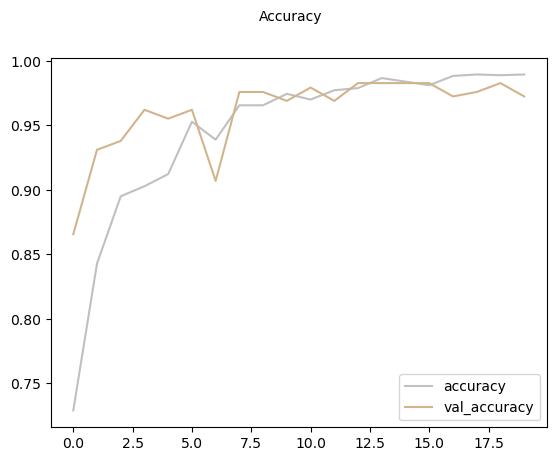

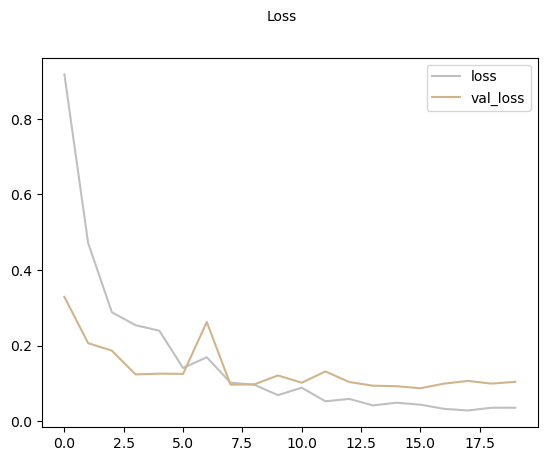

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 616ms/step
              precision    recall  f1-score   support

           0     1.0000    0.8750    0.9333        24
           1     1.0000    0.9912    0.9956       113
           2     0.9540    1.0000    0.9765        83

    accuracy                         0.9818       220
   macro avg     0.9847    0.9554    0.9685       220
weighted avg     0.9827    0.9818    0.9816       220

The Cohen's Kappa Score is: 0.9685927406402798


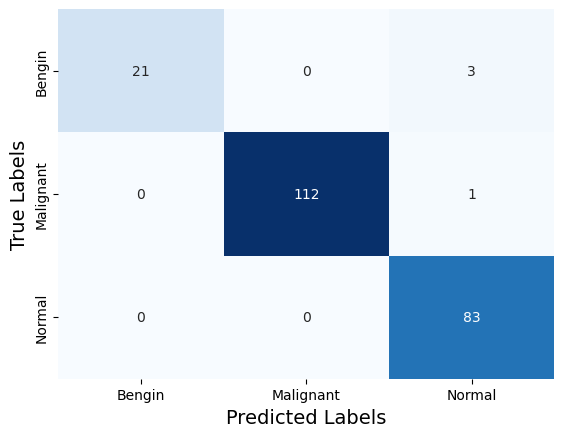

CPU times: total: 4min 8s
Wall time: 10min 48s


In [84]:
%%time

from tensorflow.keras.applications import EfficientNetV2B1

model_name = 'EfficientNetV2B1'
epoch_num = 20
batch = 16
num_classes = 3

#x_train_smt = np.repeat(x_train_smt, 3, axis=-1)
#x_val = np.expand_dims(x_val, axis=-1)
#x_val = np.repeat(x_val, 3, axis=-1)
#x_test = np.expand_dims(x_test, axis=-1)
#x_test = np.repeat(x_test, 3, axis=-1)

x_train_smt = tf.image.resize(x_train_smt, (255, 255)).numpy()
x_val = tf.image.resize(x_val, (255, 255)).numpy()
x_test = tf.image.resize(x_test, (255, 255)).numpy()

def build_model_EfficientNetV2B1():
    base_model = EfficientNetV2B1(weights='imagenet', include_top=False, include_preprocessing=False)
    base_model.trainable = True
    for layer in base_model.layers[:-10]:  
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model_EfficientNetV2B1 = build_model_EfficientNetV2B1()
model_EfficientNetV2B1.summary()

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

history_EfficientNetV2B1 = model_EfficientNetV2B1.fit(x_train_smt, y_train_smt, batch_size = batch, epochs = epoch_num, validation_data = (x_val, y_val), callbacks=[lr_reducer, tensorboard_callback])

fig = plt.figure()
plt.plot(history_EfficientNetV2B1.history['accuracy'], color='silver', label='accuracy')
plt.plot(history_EfficientNetV2B1.history['val_accuracy'], color='tan', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=10)
plt.legend(loc="lower right")
plt.show()

fig = plt.figure()
plt.plot(history_EfficientNetV2B1.history['loss'], color='silver', label='loss')
plt.plot(history_EfficientNetV2B1.history['val_loss'], color='tan', label='val_loss')
fig.suptitle('Loss', fontsize=10)
plt.legend(loc="upper right")
plt.show()

y_pred = model_EfficientNetV2B1.predict(x_test)

y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

all_evaluation(y_test_labels, y_pred_labels, model_name, epoch_num, batch)

#### EfficientNetV2B2

Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_24      │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, None,      │        864 │ input_layer_24[0… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, None,      │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, None,      │          0 │ stem_bn[0][0]     │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, None,      │      4,608 │ stem_activation[… │
│ (Conv2D)            │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, None,      │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, None,      │          0 │ block1a_project_… │
│ (Activation)        │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, None,      │      2,304 │ block1a_project_… │
│ (Conv2D)            │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, None,      │         64 │ block1b_project_… │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, None,      │          0 │ block1b_project_… │
│ (Activation)        │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, None,      │          0 │ block1b_project_… │
│ (Dropout)           │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, None,      │          0 │ block1b_drop[0][… │
│                     │ None, 16)         │            │ block1a_project_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, None,      │      9,216 │ block1b_add[0][0] │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, None,      │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, None,      │          0 │ block2a_expand_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, None,      │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, None,      │        128 │ block2a_project_

 Total params: 10,219,361 (38.98 MB)

 Trainable params: 2,134,711 (8.14 MB)

 Non-trainable params: 8,084,650 (30.84 MB)

Epoch 1/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 51s 365ms/step - accuracy: 0.6332 - loss: 1.5026 - val_accuracy: 0.8966 - val_loss: 0.3017 - learning_rate: 0.0010
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 38s 333ms/step - accuracy: 0.8241 - loss: 0.5539 - val_accuracy: 0.9276 - val_loss: 0.1725 - learning_rate: 0.0010
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 39s 342ms/step - accuracy: 0.8885 - loss: 0.3337 - val_accuracy: 0.9276 - val_loss: 0.1626 - learning_rate: 0.0010
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 37s 328ms/step - accuracy: 0.8994 - loss: 0.2773 - val_accuracy: 0.9483 - val_loss: 0.1269 - learning_rate: 0.0010
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 37s 329ms/step - accuracy: 0.9111 - loss: 0.2509 - val_accuracy: 0.9483 - val_loss: 0.1614 - learning_rate: 0.0010
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 37s 327ms/step - accuracy: 0.9256 - loss: 0.1906 - val_accuracy: 0.9345 - val_loss: 0.1799 - learning_rate: 0.0010
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 38s 335ms/step - accuracy: 0.9

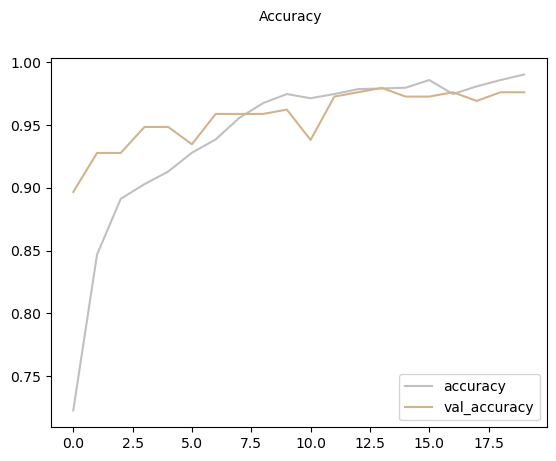

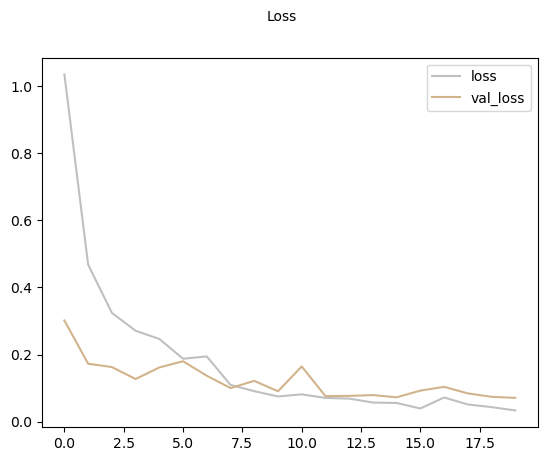

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 702ms/step
              precision    recall  f1-score   support

           0     0.9524    0.8333    0.8889        24
           1     1.0000    0.9912    0.9956       113
           2     0.9425    0.9880    0.9647        83

    accuracy                         0.9727       220
   macro avg     0.9650    0.9375    0.9497       220
weighted avg     0.9731    0.9727    0.9723       220

The Cohen's Kappa Score is: 0.9528891109604197


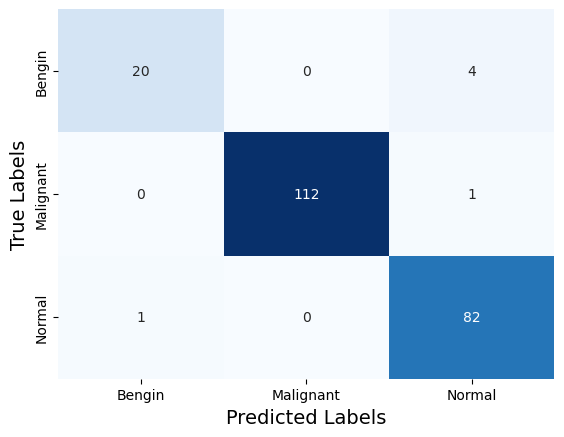

CPU times: total: 4min 58s
Wall time: 12min 54s


In [85]:
%%time

from tensorflow.keras.applications import EfficientNetV2B2

model_name = 'EfficientNetV2B2'
epoch_num = 20
batch = 16
num_classes = 3

#x_train_smt = np.repeat(x_train_smt, 3, axis=-1)
#x_val = np.expand_dims(x_val, axis=-1)
#x_val = np.repeat(x_val, 3, axis=-1)
#x_test = np.expand_dims(x_test, axis=-1)
#x_test = np.repeat(x_test, 3, axis=-1)

x_train_smt = tf.image.resize(x_train_smt, (255, 255)).numpy()
x_val = tf.image.resize(x_val, (255, 255)).numpy()
x_test = tf.image.resize(x_test, (255, 255)).numpy()

def build_model_EfficientNetV2B2():
    base_model = EfficientNetV2B2(weights='imagenet', include_top=False, include_preprocessing=False)
    base_model.trainable = True
    for layer in base_model.layers[:-10]:  
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model_EfficientNetV2B2 = build_model_EfficientNetV2B2()
model_EfficientNetV2B2.summary()

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

history_EfficientNetV2B2 = model_EfficientNetV2B2.fit(x_train_smt, y_train_smt, batch_size = batch, epochs = epoch_num, validation_data = (x_val, y_val), callbacks=[lr_reducer, tensorboard_callback])

fig = plt.figure()
plt.plot(history_EfficientNetV2B2.history['accuracy'], color='silver', label='accuracy')
plt.plot(history_EfficientNetV2B2.history['val_accuracy'], color='tan', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=10)
plt.legend(loc="lower right")
plt.show()

fig = plt.figure()
plt.plot(history_EfficientNetV2B2.history['loss'], color='silver', label='loss')
plt.plot(history_EfficientNetV2B2.history['val_loss'], color='tan', label='val_loss')
fig.suptitle('Loss', fontsize=10)
plt.legend(loc="upper right")
plt.show()

y_pred = model_EfficientNetV2B2.predict(x_test)

y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

all_evaluation(y_test_labels, y_pred_labels, model_name, epoch_num, batch)

#### EfficientNetV2B3

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_25      │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, None,      │      1,080 │ input_layer_25[0… │
│                     │ None, 40)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, None,      │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ None, 40)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, None,      │          0 │ stem_bn[0][0]     │
│ (Activation)        │ None, 40)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, None,      │      5,760 │ stem_activation[… │
│ (Conv2D)            │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, None,      │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, None,      │          0 │ block1a_project_… │
│ (Activation)        │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, None,      │      2,304 │ block1a_project_… │
│ (Conv2D)            │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, None,      │         64 │ block1b_project_… │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, None,      │          0 │ block1b_project_… │
│ (Activation)        │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, None,      │          0 │ block1b_project_… │
│ (Dropout)           │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, None,      │          0 │ block1b_drop[0][… │
│                     │ None, 16)         │            │ block1a_project_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, None,      │      9,216 │ block1b_add[0][0] │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, None,      │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, None,      │          0 │ block2a_expand_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, None,      │      2,560 │ block2a_expand_a… │
│ (Conv2D)            │ None, 40)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, None,      │        160 │ block2a_project_

 Total params: 14,511,681 (55.36 MB)

 Trainable params: 2,424,765 (9.25 MB)

 Non-trainable params: 12,086,916 (46.11 MB)

Epoch 1/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 77s 593ms/step - accuracy: 0.6268 - loss: 1.5386 - val_accuracy: 0.8379 - val_loss: 0.4407 - learning_rate: 0.0010
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 68s 605ms/step - accuracy: 0.8207 - loss: 0.5739 - val_accuracy: 0.9172 - val_loss: 0.2124 - learning_rate: 0.0010
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 68s 604ms/step - accuracy: 0.8748 - loss: 0.3597 - val_accuracy: 0.8897 - val_loss: 0.2836 - learning_rate: 0.0010
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 68s 605ms/step - accuracy: 0.8996 - loss: 0.2855 - val_accuracy: 0.9241 - val_loss: 0.2196 - learning_rate: 0.0010
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 68s 606ms/step - accuracy: 0.9282 - loss: 0.2036 - val_accuracy: 0.9172 - val_loss: 0.2369 - learning_rate: 0.0010
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 68s 605ms/step - accuracy: 0.9387 - loss: 0.1683 - val_accuracy: 0.9414 - val_loss: 0.1456 - learning_rate: 5.0000e-04
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 68s 604ms/step - accuracy:

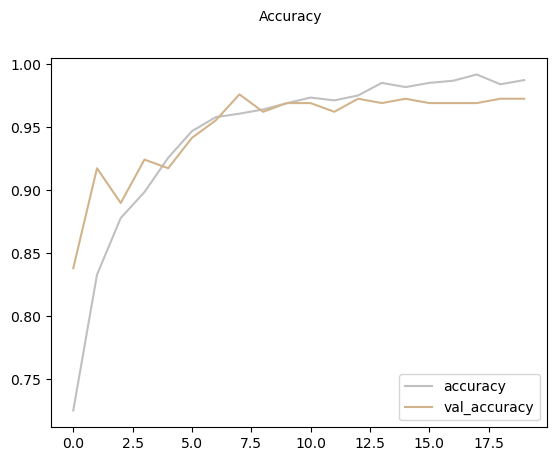

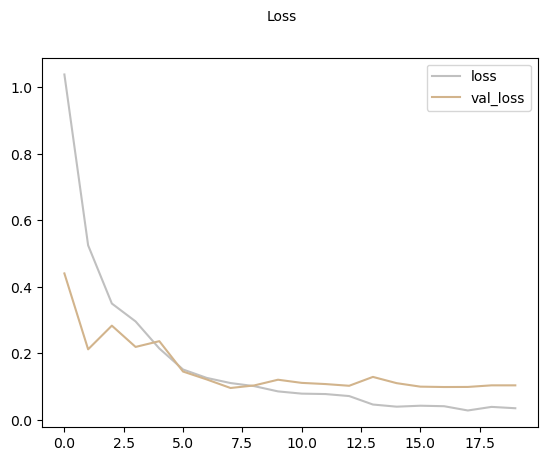

7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step  
              precision    recall  f1-score   support

           0     0.9565    0.9167    0.9362        24
           1     0.9912    1.0000    0.9956       113
           2     0.9759    0.9759    0.9759        83

    accuracy                         0.9818       220
   macro avg     0.9746    0.9642    0.9692       220
weighted avg     0.9817    0.9818    0.9817       220

The Cohen's Kappa Score is: 0.9686576201161092


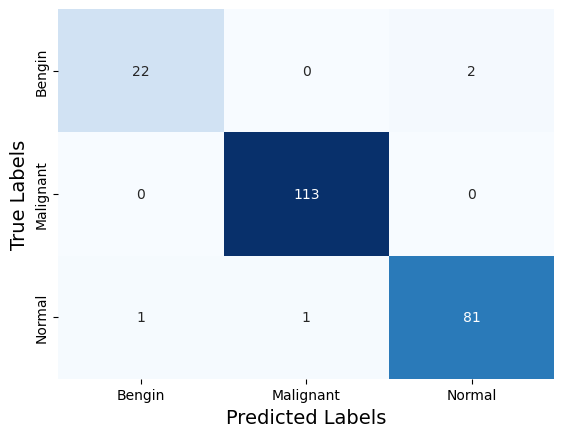

CPU times: total: 6min 58s
Wall time: 23min 6s


In [86]:
%%time

from tensorflow.keras.applications import EfficientNetV2B3

model_name = 'EfficientNetV2B3'
epoch_num = 20
batch = 16
num_classes = 3

#x_train_smt = np.repeat(x_train_smt, 3, axis=-1)
#x_val = np.expand_dims(x_val, axis=-1)
#x_val = np.repeat(x_val, 3, axis=-1)
#x_test = np.expand_dims(x_test, axis=-1)
#x_test = np.repeat(x_test, 3, axis=-1)

x_train_smt = tf.image.resize(x_train_smt, (255, 255)).numpy()
x_val = tf.image.resize(x_val, (255, 255)).numpy()
x_test = tf.image.resize(x_test, (255, 255)).numpy()

def build_model_EfficientNetV2B3():
    base_model = EfficientNetV2B3(weights='imagenet', include_top=False, include_preprocessing=False)
    base_model.trainable = True
    for layer in base_model.layers[:-10]:  
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model_EfficientNetV2B3 = build_model_EfficientNetV2B3()
model_EfficientNetV2B3.summary()

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

history_EfficientNetV2B3 = model_EfficientNetV2B3.fit(x_train_smt, y_train_smt, batch_size = batch, epochs = epoch_num, validation_data = (x_val, y_val), callbacks=[lr_reducer, tensorboard_callback])

fig = plt.figure()
plt.plot(history_EfficientNetV2B3.history['accuracy'], color='silver', label='accuracy')
plt.plot(history_EfficientNetV2B3.history['val_accuracy'], color='tan', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=10)
plt.legend(loc="lower right")
plt.show()

fig = plt.figure()
plt.plot(history_EfficientNetV2B3.history['loss'], color='silver', label='loss')
plt.plot(history_EfficientNetV2B3.history['val_loss'], color='tan', label='val_loss')
fig.suptitle('Loss', fontsize=10)
plt.legend(loc="upper right")
plt.show()

y_pred = model_EfficientNetV2B3.predict(x_test)

y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

all_evaluation(y_test_labels, y_pred_labels, model_name, epoch_num, batch)

### DenseNet 121, 169, 201

#### DenseNet 121

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_8    │ (None, 230, 230,  │          0 │ input_layer_12[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_8… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_9    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_9… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 8,094,275 (30.88 MB)

 Trainable params: 1,222,851 (4.66 MB)

 Non-trainable params: 6,871,424 (26.21 MB)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 53s 802ms/step - accuracy: 0.7469 - loss: 0.7140 - val_accuracy: 0.8310 - val_loss: 0.3640 - learning_rate: 0.0010
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 43s 757ms/step - accuracy: 0.9520 - loss: 0.1559 - val_accuracy: 0.9310 - val_loss: 0.1635 - learning_rate: 0.0010
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 44s 773ms/step - accuracy: 0.9839 - loss: 0.0511 - val_accuracy: 0.9690 - val_loss: 0.0956 - learning_rate: 0.0010
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 42s 741ms/step - accuracy: 0.9938 - loss: 0.0209 - val_accuracy: 0.9724 - val_loss: 0.1155 - learning_rate: 0.0010
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 42s 741ms/step - accuracy: 0.9987 - loss: 0.0065 - val_accuracy: 0.9690 - val_loss: 0.1510 - learning_rate: 0.0010
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 42s 744ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9793 - val_loss: 0.0926 - learning_rate: 0.0010
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 42s 739ms/step - accuracy: 1.0000 - loss: 0.

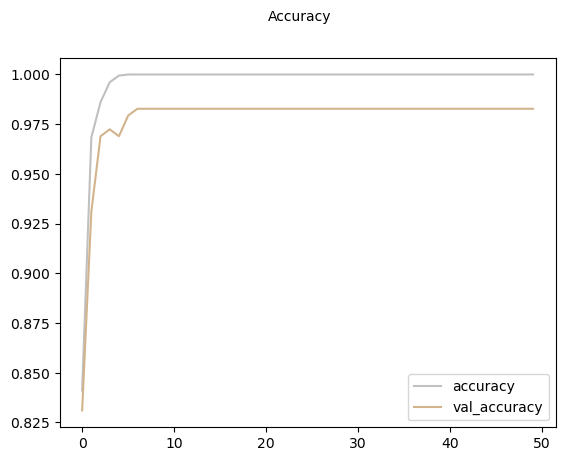

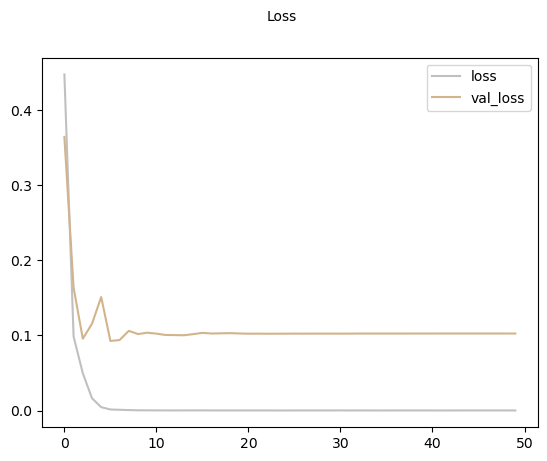

7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 987ms/step
              precision    recall  f1-score   support

           0     1.0000    0.7083    0.8293        24
           1     0.9826    1.0000    0.9912       113
           2     0.9318    0.9880    0.9591        83

    accuracy                         0.9636       220
   macro avg     0.9715    0.8988    0.9265       220
weighted avg     0.9653    0.9636    0.9614       220

The Cohen's Kappa Score is: 0.9364460332936121


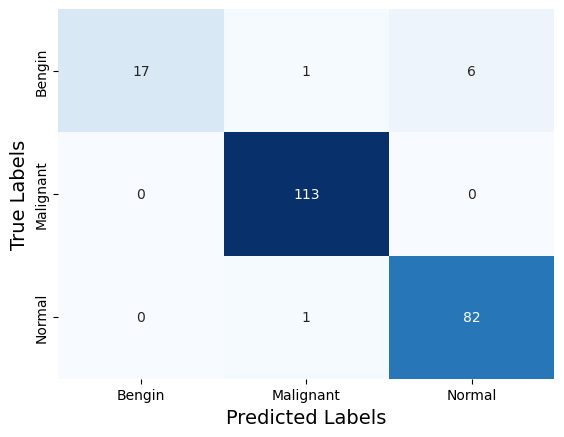

CPU times: total: 21min 20s
Wall time: 35min 43s


In [54]:
%%time
from tensorflow.keras.applications import DenseNet121

model_name = 'densenet121'
epoch_num = 50
batch = 32
num_classes = 3

#x_train_smt = np.repeat(x_train_smt, 3, axis=-1)
#x_val = np.expand_dims(x_val, axis=-1)
#x_val = np.repeat(x_val, 3, axis=-1)
#x_test = np.expand_dims(x_test, axis=-1)
#x_test = np.repeat(x_test, 3, axis=-1)

x_train_smt = tf.image.resize(x_train_smt, (224, 224)).numpy()
x_val = tf.image.resize(x_val, (224, 224)).numpy()
x_test = tf.image.resize(x_test, (224, 224)).numpy()


def build_model_DenseNet121():
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = True
    for layer in base_model.layers[:-10]:  
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model_DenseNet121 = build_model_DenseNet121()
model_DenseNet121.summary()

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

history_DenseNet121 = model_DenseNet121.fit(x_train_smt, y_train_smt, batch_size = batch, epochs = epoch_num, validation_data = (x_val, y_val), callbacks=[lr_reducer, tensorboard_callback])

fig = plt.figure()
plt.plot(history_DenseNet121.history['accuracy'], color='silver', label='accuracy')
plt.plot(history_DenseNet121.history['val_accuracy'], color='tan', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=10)
plt.legend(loc="lower right")
plt.show()

fig = plt.figure()
plt.plot(history_DenseNet121.history['loss'], color='silver', label='loss')
plt.plot(history_DenseNet121.history['val_loss'], color='tan', label='val_loss')
fig.suptitle('Loss', fontsize=10)
plt.legend(loc="upper right")
plt.show()

y_pred = model_DenseNet121.predict(x_test)

y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

all_evaluation(y_test_labels, y_pred_labels, model_name, epoch_num, batch)

#### DenseNet1 169

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_4    │ (None, 230, 230,  │          0 │ input_layer_6[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_4… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_5    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_5… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 14,355,011 (54.76 MB)

 Trainable params: 1,962,691 (7.49 MB)

 Non-trainable params: 12,392,320 (47.27 MB)

Epoch 1/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 55s 389ms/step - accuracy: 0.7542 - loss: 0.7010 - val_accuracy: 0.9345 - val_loss: 0.1623 - learning_rate: 0.0010
Epoch 2/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 45s 399ms/step - accuracy: 0.9621 - loss: 0.1133 - val_accuracy: 0.8448 - val_loss: 0.4540 - learning_rate: 0.0010
Epoch 3/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 45s 395ms/step - accuracy: 0.9644 - loss: 0.0828 - val_accuracy: 0.9345 - val_loss: 0.2466 - learning_rate: 0.0010
Epoch 4/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 45s 396ms/step - accuracy: 0.9901 - loss: 0.0308 - val_accuracy: 0.9552 - val_loss: 0.2558 - learning_rate: 0.0010
Epoch 5/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 43s 382ms/step - accuracy: 0.9957 - loss: 0.0167 - val_accuracy: 0.9621 - val_loss: 0.1554 - learning_rate: 5.0000e-04
Epoch 6/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 45s 396ms/step - accuracy: 0.9985 - loss: 0.0050 - val_accuracy: 0.9690 - val_loss: 0.1824 - learning_rate: 5.0000e-04
Epoch 7/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 46s 405ms/step - accur

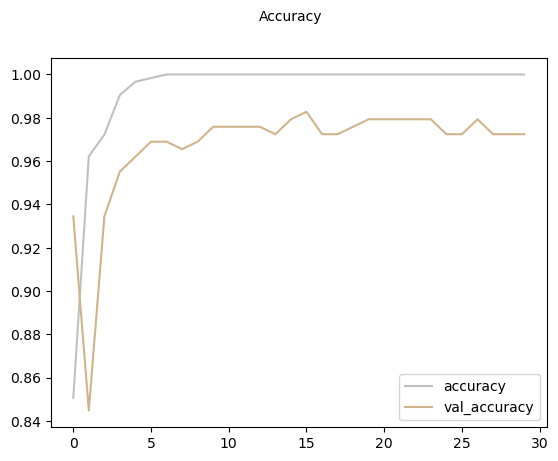

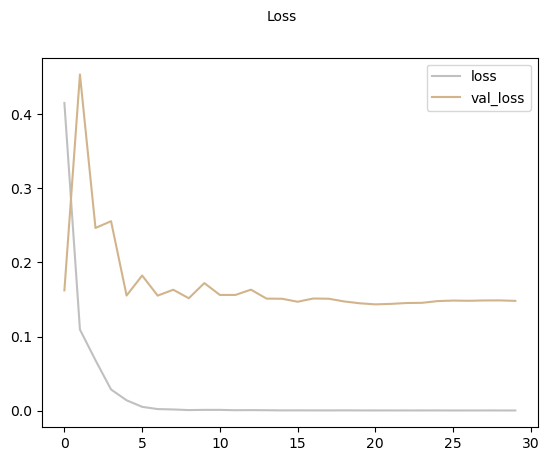

7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 986ms/step
              precision    recall  f1-score   support

           0     0.9524    0.8333    0.8889        24
           1     0.9912    1.0000    0.9956       113
           2     0.9647    0.9880    0.9762        83

    accuracy                         0.9773       220
   macro avg     0.9694    0.9404    0.9536       220
weighted avg     0.9770    0.9773    0.9766       220

The Cohen's Kappa Score is: 0.9606566758467756


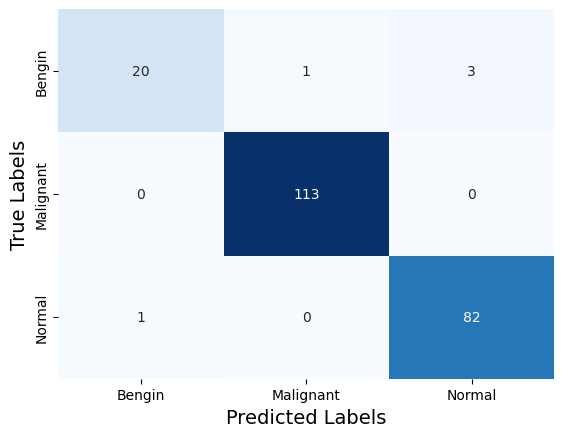

CPU times: total: 15min 22s
Wall time: 22min 23s


In [39]:
%%time
from tensorflow.keras.applications import DenseNet169

model_name = 'densenet169'
epoch_num = 30
batch = 16
num_classes = 3

#x_train_smt = np.repeat(x_train_smt, 3, axis=-1)
#x_val = np.expand_dims(x_val, axis=-1)
#x_val = np.repeat(x_val, 3, axis=-1)
#x_test = np.expand_dims(x_test, axis=-1)
#x_test = np.repeat(x_test, 3, axis=-1)

x_train_smt = tf.image.resize(x_train_smt, (224, 224)).numpy()
x_val = tf.image.resize(x_val, (224, 224)).numpy()
x_test = tf.image.resize(x_test, (224, 224)).numpy()


def build_model_DenseNet169():
    base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = True
    for layer in base_model.layers[:-10]:  
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model_DenseNet169 = build_model_DenseNet169()
model_DenseNet169.summary()

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

history_DenseNet169 = model_DenseNet169.fit(x_train_smt, y_train_smt, batch_size = batch, epochs = epoch_num, validation_data = (x_val, y_val), callbacks=[lr_reducer, tensorboard_callback])

fig = plt.figure()
plt.plot(history_DenseNet169.history['accuracy'], color='silver', label='accuracy')
plt.plot(history_DenseNet169.history['val_accuracy'], color='tan', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=10)
plt.legend(loc="lower right")
plt.show()

fig = plt.figure()
plt.plot(history_DenseNet169.history['loss'], color='silver', label='loss')
plt.plot(history_DenseNet169.history['val_loss'], color='tan', label='val_loss')
fig.suptitle('Loss', fontsize=10)
plt.legend(loc="upper right")
plt.show()

y_pred = model_DenseNet169.predict(x_test)

y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

all_evaluation(y_test_labels, y_pred_labels, model_name, epoch_num, batch)

#### DenseNet 201

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_6    │ (None, 230, 230,  │          0 │ input_layer_11[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_6… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_7    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_7… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 20,296,259 (77.42 MB)

 Trainable params: 2,258,627 (8.62 MB)

 Non-trainable params: 18,037,632 (68.81 MB)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.7583 - loss: 0.7620 - val_accuracy: 0.7034 - val_loss: 0.6870 - learning_rate: 0.0010
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.9686 - loss: 0.0872 - val_accuracy: 0.9379 - val_loss: 0.1881 - learning_rate: 0.0010
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.9900 - loss: 0.0322 - val_accuracy: 0.8655 - val_loss: 0.3835 - learning_rate: 0.0010
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.9954 - loss: 0.0217 - val_accuracy: 0.9345 - val_loss: 0.2240 - learning_rate: 0.0010
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.9997 - loss: 0.0079 - val_accuracy: 0.9655 - val_loss: 0.1773 - learning_rate: 0.0010
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.9999 - loss: 0.0034 - val_accuracy: 0.9655 - val_loss: 0.1699 - learning_rate: 0.0010
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 

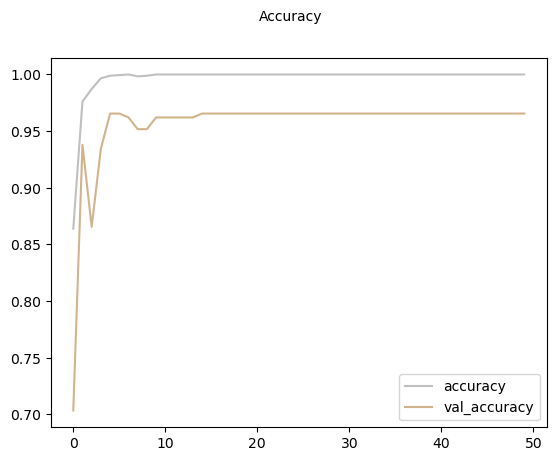

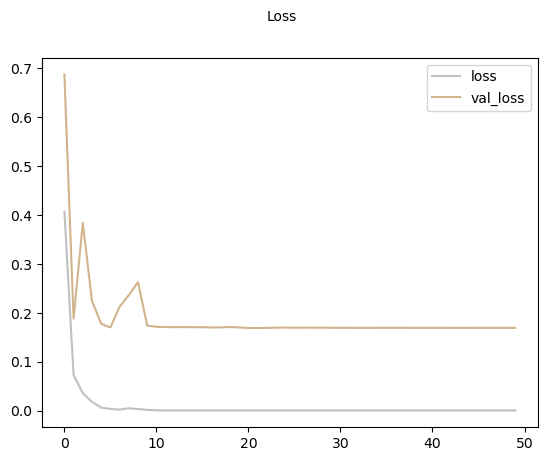

7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step 
              precision    recall  f1-score   support

           0     0.9474    0.7500    0.8372        24
           1     0.9912    1.0000    0.9956       113
           2     0.9310    0.9759    0.9529        83

    accuracy                         0.9636       220
   macro avg     0.9565    0.9086    0.9286       220
weighted avg     0.9637    0.9636    0.9622       220

The Cohen's Kappa Score is: 0.9367838798893717


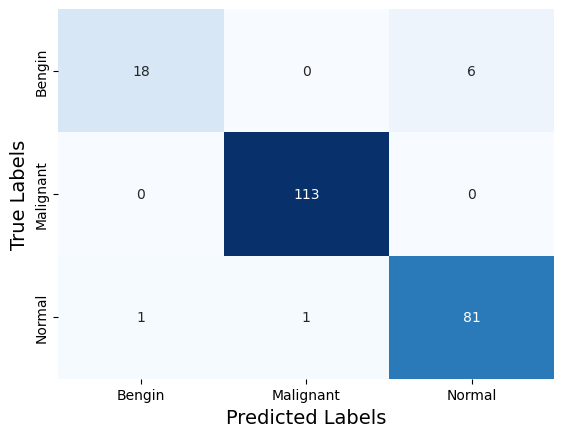

CPU times: total: 35min 19s
Wall time: 53min 43s


In [49]:
%%time
from tensorflow.keras.applications import DenseNet201

model_name = 'densenet201'
epoch_num = 50
batch = 32
num_classes = 3

#x_train_smt = np.repeat(x_train_smt, 3, axis=-1)
#x_val = np.expand_dims(x_val, axis=-1)
#x_val = np.repeat(x_val, 3, axis=-1)
#x_test = np.expand_dims(x_test, axis=-1)
#x_test = np.repeat(x_test, 3, axis=-1)

x_train_smt = tf.image.resize(x_train_smt, (224, 224)).numpy()
x_val = tf.image.resize(x_val, (224, 224)).numpy()
x_test = tf.image.resize(x_test, (224, 224)).numpy()


def build_model_DenseNet201():
    base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = True
    for layer in base_model.layers[:-10]:  
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model_DenseNet201 = build_model_DenseNet201()
model_DenseNet201.summary()

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

history_DenseNet201 = model_DenseNet201.fit(x_train_smt, y_train_smt, batch_size = batch, epochs = epoch_num, validation_data = (x_val, y_val), callbacks=[lr_reducer, tensorboard_callback])

fig = plt.figure()
plt.plot(history_DenseNet201.history['accuracy'], color='silver', label='accuracy')
plt.plot(history_DenseNet201.history['val_accuracy'], color='tan', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=10)
plt.legend(loc="lower right")
plt.show()

fig = plt.figure()
plt.plot(history_DenseNet201.history['loss'], color='silver', label='loss')
plt.plot(history_DenseNet201.history['val_loss'], color='tan', label='val_loss')
fig.suptitle('Loss', fontsize=10)
plt.legend(loc="upper right")
plt.show()

y_pred = model_DenseNet201.predict(x_test)

y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

all_evaluation(y_test_labels, y_pred_labels, model_name, epoch_num, batch)

### Using InceptionResNetV2

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 149, 149,  │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 149, 149,  │         96 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 147, 147,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 147, 147,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 73, 73,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 73, 73,    │      5,120 │ max_pooling2d_6[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 71, 71,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 55,917,795 (213.31 MB)

 Trainable params: 5,709,795 (21.78 MB)

 Non-trainable params: 50,208,000 (191.53 MB)

Epoch 1/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 350s 11s/step - accuracy: 0.6747 - loss: 1.0148 - val_accuracy: 0.7103 - val_loss: 0.8778 - learning_rate: 0.0010
Epoch 2/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 326s 11s/step - accuracy: 0.8726 - loss: 0.3700 - val_accuracy: 0.7621 - val_loss: 0.6288 - learning_rate: 0.0010
Epoch 3/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 321s 11s/step - accuracy: 0.9523 - loss: 0.1439 - val_accuracy: 0.7552 - val_loss: 0.8314 - learning_rate: 0.0010
Epoch 4/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 324s 11s/step - accuracy: 0.9700 - loss: 0.0769 - val_accuracy: 0.8862 - val_loss: 0.3245 - learning_rate: 0.0010
Epoch 5/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 331s 11s/step - accuracy: 0.9843 - loss: 0.0408 - val_accuracy: 0.8517 - val_loss: 0.4748 - learning_rate: 0.0010
Epoch 6/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 322s 11s/step - accuracy: 0.9728 - loss: 0.0595 - val_accuracy: 0.8276 - val_loss: 0.6554 - learning_rate: 0.0010
Epoch 7/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 329s 11s/step - accuracy: 0.9713 - loss: 0.0761 - 

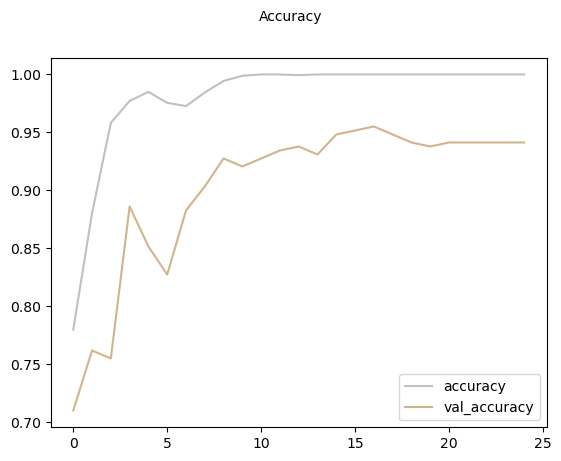

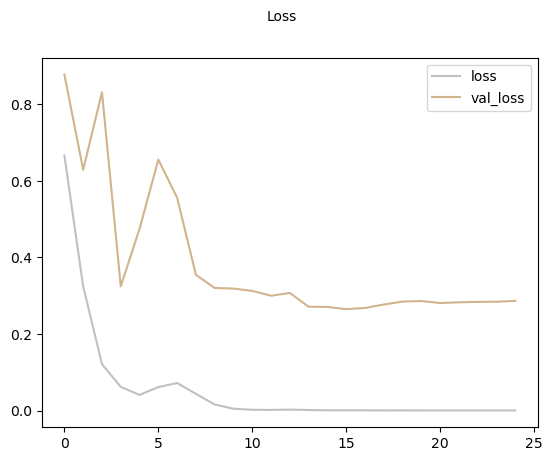

7/7 ━━━━━━━━━━━━━━━━━━━━ 49s 6s/step
              precision    recall  f1-score   support

           0     0.8824    0.6250    0.7317        24
           1     1.0000    0.9823    0.9911       113
           2     0.8804    0.9759    0.9257        83

    accuracy                         0.9409       220
   macro avg     0.9209    0.8611    0.8828       220
weighted avg     0.9421    0.9409    0.9381       220

The Cohen's Kappa Score is: 0.8971703879480819


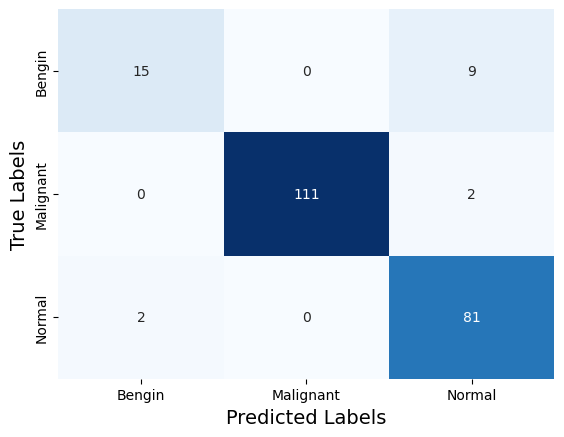

CPU times: total: 9h 58min 20s
Wall time: 2h 17min 46s


In [33]:
%%time
from tensorflow.keras.applications import InceptionResNetV2

model_name = 'inceptionresnetv2'
epoch_num = 25
batch = 64
num_classes = 3

#x_train_smt = np.repeat(x_train_smt, 3, axis=-1)
#x_val = np.expand_dims(x_val, axis=-1)
#x_val = np.repeat(x_val, 3, axis=-1)
#x_test = np.expand_dims(x_test, axis=-1)
#x_test = np.repeat(x_test, 3, axis=-1)

x_train_smt = tf.image.resize(x_train_smt, (299, 299)).numpy()
x_val = tf.image.resize(x_val, (299, 299)).numpy()
x_test = tf.image.resize(x_test, (299, 299)).numpy()


def build_model_inceptionresnetv2():
    base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
    base_model.trainable = True
    for layer in base_model.layers[:-10]:  
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model_inceptionresnetv2 = build_model_inceptionresnetv2()
model_inceptionresnetv2.summary()

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

history_inceptionresnetv2 = model_inceptionresnetv2.fit(x_train_smt, y_train_smt,batch_size = batch, epochs = epoch_num, validation_data = (x_val, y_val), callbacks=[lr_reducer, tensorboard_callback])

fig = plt.figure()
plt.plot(history_inceptionresnetv2.history['accuracy'], color='silver', label='accuracy')
plt.plot(history_inceptionresnetv2.history['val_accuracy'], color='tan', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=10)
plt.legend(loc="lower right")
plt.show()

fig = plt.figure()
plt.plot(history_inceptionresnetv2.history['loss'], color='silver', label='loss')
plt.plot(history_inceptionresnetv2.history['val_loss'], color='tan', label='val_loss')
fig.suptitle('Loss', fontsize=10)
plt.legend(loc="upper right")
plt.show()

y_pred = model_inceptionresnetv2.predict(x_test)

y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

all_evaluation(y_test_labels, y_pred_labels, model_name, epoch_num, batch)

### Using Model Soup Basic-L

# Hyperparameter tuning

In [75]:
def tuning_evaluation(
                    y_test_labels, y_pred_labels, model, epoch_num,
                    batch, lr, unfreeze_layer, do_rt, tuning_type
):
    output_path = 'output_tuning\\' + model + '_epoch' + str(epoch_num)
    + '_batch' + str(batch) + '_lr' + str(lr)
    + '_unfreeze' + str(unfreeze_layer) + '_doRt' + str(do_rt)
    + str(tuning_type)
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    # Accuracy, precision, recall, f1 score
    print(metrics.classification_report(y_test_labels, y_pred_labels, digits=4))
    report = metrics.classification_report(y_test_labels, y_pred_labels, digits=4)
    cm = metrics.confusion_matrix(y_test_labels, y_pred_labels)
    
    print(f"The Cohen's Kappa Score is: {metrics.cohen_kappa_score(y_test_labels, y_pred_labels)}")
    cohen = metrics.cohen_kappa_score(y_test_labels, y_pred_labels)
    with open(output_path + '\\evaluation_report.txt', 'w') as f:
        f.write(report)
        f.write('\n')
        f.write('The Cohen\'s Kappa Score is: ' + str(cohen))
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Bengin', 'Malignant', 'Normal'],
                yticklabels=['Bengin', 'Malignant', 'Normal'])
    plt.xlabel("Predicted Labels", fontsize=14)
    plt.ylabel("True Labels", fontsize=14)
    plt.savefig(output_path + '\\confusion_matrix.jpg')
    plt.show()

### CNN tuning

### ResNet50V2 tuning

In [94]:
def build_model_ResNet50V2_tuning(hp):
    base_model = ResNet50V2(weights='imagenet', include_top=False)
    base_model.trainable = True
    unfreeze = hp.Int("unfreeze_layer", min_value=10, max_value=len(base_model.layers), step=10)
    for layer in base_model.layers[:-unfreeze]:  
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    do_config = hp.Float("dropout", min_value=0.2, max_value=0.6, step=0.1)
    x = Dropout(do_config)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice("learning_rate", values=[1e-6, 1e-7, 1e-8])
        ),
        loss='categorical_crossentropy', 
        metrics=['accuracy'])
    return model

tuner = kt.BayesianOptimization(
    hypermodel=build_model_ResNet50V2_tuning,
    objective = "val_accuracy",
    max_trials=20,
    executions_per_trial=1,
    directory='tuning_logs',
    project_name='resnet50v2_bayesianO',
    seed=42  
)

tuner.search(
    x_train_smt, y_train_smt,
    validation_data=(x_val, y_val),
    epochs=kt.HyperParameters().Int(
        "epochs", min_value=20, max_value=70, step=10
    ),
    batch_size=kt.HyperParameters().Int(
        "batch_size", min_value=16, max_value=64, step=16
    )
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

best_model.summary()


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
130               |130               |unfreeze_layer
0.2               |0.2               |dropout
1e-07             |1e-07             |learning_rate



KeyboardInterrupt: 

### EfficientNetV2 variations tuning

#### EfficientNetV2B0

In [ ]:
from tensorflow.keras.applications import EfficientNetV2B0

def build_model_EfficientNetV2B0_tuning(hp):
    base_model = EfficientNetV2B0(weights='imagenet', include_top=False)
    base_model.trainable = True
    unfreeze = hp.Int("unfreeze_layer", min_value=10, max_value=len(base_model.layers), step=10)
    for layer in base_model.layers[:-unfreeze]:  
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    do_config = hp.Float("dropout", min_value=0.2, max_value=0.6, step=0.1)
    x = Dropout(do_config)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice("learning_rate", values=[1e-6, 1e-7, 1e-8])
        ),
        loss='categorical_crossentropy', 
        metrics=['accuracy'])
    return model

tuner = kt.BayesianOptimization(
    hypermodel=build_model_EfficientNetV2B0_tuning,
    objective = "val_accuracy",
    max_trials=20,
    executions_per_trial=1,
    directory='tuning_logs',
    project_name='EfficientNetV2B0_bayesianO',
    seed=42  
)

tuner.search(
    x_train_smt, y_train_smt,
    validation_data=(x_val, y_val),
    epochs=kt.HyperParameters().Int(
        "epochs", min_value=20, max_value=70, step=10
    ),
    batch_size=kt.HyperParameters().Int(
        "batch_size", min_value=16, max_value=64, step=16
    )
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

best_model.summary()

#### EfficientNetV2B1

In [ ]:
from tensorflow.keras.applications import EfficientNetV2B1

def build_model_EfficientNetV2B1_tuning(hp):
    base_model = EfficientNetV2B1(weights='imagenet', include_top=False)
    base_model.trainable = True
    unfreeze = hp.Int("unfreeze_layer", min_value=10, max_value=len(base_model.layers), step=10)
    for layer in base_model.layers[:-unfreeze]:  
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    do_config = hp.Float("dropout", min_value=0.2, max_value=0.6, step=0.1)
    x = Dropout(do_config)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice("learning_rate", values=[1e-6, 1e-7, 1e-8])
        ),
        loss='categorical_crossentropy', 
        metrics=['accuracy'])
    return model

tuner = kt.BayesianOptimization(
    hypermodel=build_model_EfficientNetV2B1_tuning,
    objective = "val_accuracy",
    max_trials=20,
    executions_per_trial=1,
    directory='tuning_logs',
    project_name='EfficientNetV2B1_bayesianO',
    seed=42  
)

tuner.search(
    x_train_smt, y_train_smt,
    validation_data=(x_val, y_val),
    epochs=kt.HyperParameters().Int(
        "epochs", min_value=20, max_value=70, step=10
    ),
    batch_size=kt.HyperParameters().Int(
        "batch_size", min_value=16, max_value=64, step=16
    )
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

best_model.summary()

#### EfficientNetV2B2

In [ ]:
from tensorflow.keras.applications import EfficientNetV2B2

def build_model_EfficientNetV2B2_tuning(hp):
    base_model = EfficientNetV2B2(weights='imagenet', include_top=False)
    base_model.trainable = True
    unfreeze = hp.Int("unfreeze_layer", min_value=10, max_value=len(base_model.layers), step=10)
    for layer in base_model.layers[:-unfreeze]:  
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    do_config = hp.Float("dropout", min_value=0.2, max_value=0.6, step=0.1)
    x = Dropout(do_config)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice("learning_rate", values=[1e-6, 1e-7, 1e-8])
        ),
        loss='categorical_crossentropy', 
        metrics=['accuracy'])
    return model

tuner = kt.BayesianOptimization(
    hypermodel=build_model_EfficientNetV2B2_tuning,
    objective = "val_accuracy",
    max_trials=20,
    executions_per_trial=1,
    directory='tuning_logs',
    project_name='EfficientNetV2B2_bayesianO',
    seed=42  
)

tuner.search(
    x_train_smt, y_train_smt,
    validation_data=(x_val, y_val),
    epochs=kt.HyperParameters().Int(
        "epochs", min_value=20, max_value=70, step=10
    ),
    batch_size=kt.HyperParameters().Int(
        "batch_size", min_value=16, max_value=64, step=16
    )
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

best_model.summary()

#### EfficientNetV2B3

In [ ]:
from tensorflow.keras.applications import EfficientNetV2B3

def build_model_EfficientNetV2B3_tuning(hp):
    base_model = EfficientNetV2B3(weights='imagenet', include_top=False)
    base_model.trainable = True
    unfreeze = hp.Int("unfreeze_layer", min_value=10, max_value=len(base_model.layers), step=10)
    for layer in base_model.layers[:-unfreeze]:  
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    do_config = hp.Float("dropout", min_value=0.2, max_value=0.6, step=0.1)
    x = Dropout(do_config)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice("learning_rate", values=[1e-6, 1e-7, 1e-8])
        ),
        loss='categorical_crossentropy', 
        metrics=['accuracy'])
    return model

tuner = kt.BayesianOptimization(
    hypermodel=build_model_EfficientNetV2B3_tuning,
    objective = "val_accuracy",
    max_trials=20,
    executions_per_trial=1,
    directory='tuning_logs',
    project_name='EfficientNetV2B3_bayesianO',
    seed=42  
)

tuner.search(
    x_train_smt, y_train_smt,
    validation_data=(x_val, y_val),
    epochs=kt.HyperParameters().Int(
        "epochs", min_value=20, max_value=70, step=10
    ),
    batch_size=kt.HyperParameters().Int(
        "batch_size", min_value=16, max_value=64, step=16
    )
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

best_model.summary()

### InceptionResNetV2 tuning

In [77]:
from tensorflow.keras.applications import InceptionResNetV2

def build_model_InceptionResNetV2_tuning(hp):
    base_model = InceptionResNetV2(weights='imagenet', include_top=False)
    base_model.trainable = True
    unfreeze = hp.Int("unfreeze_layer", min_value=10, max_value=len(base_model.layers), step=10)
    for layer in base_model.layers[:-unfreeze]:  
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    do_config = hp.Float("dropout", min_value=0.2, max_value=0.6, step=0.1)
    x = Dropout(do_config)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice("learning_rate", values=[1e-6, 1e-7, 1e-8])
        ),
        loss='categorical_crossentropy', 
        metrics=['accuracy'])
    return model

tuner = kt.BayesianOptimization(
    hypermodel=build_model_InceptionResNetV2_tuning,
    objective = "val_accuracy",
    max_trials=20,
    executions_per_trial=1,
    directory='tuning_logs',
    project_name='InceptionResNetV2_bayesianO',
    seed=42  
)

tuner.search(
    x_train_smt, y_train_smt,
    validation_data=(x_val, y_val),
    epochs=kt.HyperParameters().Int(
        "epochs", min_value=20, max_value=70, step=10
    ),
    batch_size=kt.HyperParameters().Int(
        "batch_size", min_value=16, max_value=64, step=16
    )
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

best_model.summary()


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
500               |500               |unfreeze_layer
0.2               |0.2               |dropout
1e-07             |1e-07             |learning_rate

Epoch 1/20
  6/113 ━━━━━━━━━━━━━━━━━━━━ 2:09 1s/step - accuracy: 0.2174 - loss: 1.7763

KeyboardInterrupt: 

### NasNetMobile tuning

In [ ]:
from tensorflow.keras.applications import NASNetMobile

def build_model_NasNetMobile_tuning(hp):
    base_model = NASNetMobile(weights='imagenet', include_top=False)
    base_model.trainable = True
    unfreeze = hp.Int("unfreeze_layer", min_value=10, max_value=len(base_model.layers), step=10)
    for layer in base_model.layers[:-unfreeze]:  
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    do_config = hp.Float("dropout", min_value=0.2, max_value=0.6, step=0.1)
    x = Dropout(do_config)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice("learning_rate", values=[1e-6, 1e-7, 1e-8])
        ),
        loss='categorical_crossentropy', 
        metrics=['accuracy'])
    return model

tuner = kt.BayesianOptimization(
    hypermodel=build_model_NasNetMobile_tuning,
    objective = "val_accuracy",
    max_trials=20,
    executions_per_trial=1,
    directory='tuning_logs',
    project_name='nasnetmobile_bayesianO',
    seed=42  
)

tuner.search(
    x_train_smt, y_train_smt,
    validation_data=(x_val, y_val),
    epochs=kt.HyperParameters().Int(
        "epochs", min_value=20, max_value=70, step=10
    ),
    batch_size=kt.HyperParameters().Int(
        "batch_size", min_value=16, max_value=64, step=16
    )
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

best_model.summary()

### MobileNetV2 tuning

In [53]:
from tensorflow.keras.applications import MobileNetV2

def build_model_MobileNetV2_tuning(hp):
    base_model = MobileNetV2(weights='imagenet', include_top=False)
    base_model.trainable = True
    unfreeze = hp.Int("unfreeze_layer", min_value=10, max_value=len(base_model.layers), step=10)
    for layer in base_model.layers[:-unfreeze]:  
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    do_config = hp.Float("dropout", min_value=0.2, max_value=0.6, step=0.1)
    x = Dropout(do_config)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice("learning_rate", values=[1e-6, 1e-7, 1e-8])
        ),
        loss='categorical_crossentropy', 
        metrics=['accuracy'])
    return model

tuner = kt.BayesianOptimization(
    hypermodel=build_model_MobileNetV2_tuning,
    objective = "val_accuracy",
    max_trials=20,
    executions_per_trial=1,
    directory='tuning_logs',
    project_name='mobilenetv2_bayesianO',
    seed=42  
)

tuner.search(
    x_train_smt, y_train_smt,
    validation_data=(x_val, y_val),
    epochs=kt.HyperParameters().Int(
        "epochs", min_value=20, max_value=70, step=10
    ),
    batch_size=kt.HyperParameters().Int(
        "batch_size", min_value=16, max_value=64, step=16
    )
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

best_model.summary()

C:\Users\ivans\AppData\Local\Temp\ipykernel_8252\1115541597.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False)



Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
100               |100               |unfreeze_layer
0.2               |0.2               |dropout
1e-07             |1e-07             |learning_rate

Epoch 1/20
 30/113 ━━━━━━━━━━━━━━━━━━━━ 15s 191ms/step - accuracy: 0.3396 - loss: 1.6390

KeyboardInterrupt: 

### DenseNet variations tuning

#### DenseNet 121

In [ ]:
from tensorflow.keras.applications import DenseNet121

def build_model_DenseNet121_tuning(hp):
    base_model = DenseNet121(weights='imagenet', include_top=False)
    base_model.trainable = True
    unfreeze = hp.Int("unfreeze_layer", min_value=10, max_value=len(base_model.layers), step=10)
    for layer in base_model.layers[:-unfreeze]:  
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    do_config = hp.Float("dropout", min_value=0.2, max_value=0.6, step=0.1)
    x = Dropout(do_config)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice("learning_rate", values=[1e-6, 1e-7, 1e-8])
        ),
        loss='categorical_crossentropy', 
        metrics=['accuracy'])
    return model

tuner = kt.BayesianOptimization(
    hypermodel=build_model_DenseNet121_tuning,
    objective = "val_accuracy",
    max_trials=20,
    executions_per_trial=1,
    directory='tuning_logs',
    project_name='DenseNet121_bayesianO',
    seed=42  
)

tuner.search(
    x_train_smt, y_train_smt,
    validation_data=(x_val, y_val),
    epochs=kt.HyperParameters().Int(
        "epochs", min_value=20, max_value=70, step=10
    ),
    batch_size=kt.HyperParameters().Int(
        "batch_size", min_value=16, max_value=64, step=16
    )
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

best_model.summary()

#### DenseNet 169 

In [ ]:
from tensorflow.keras.applications import DenseNet169

def build_model_DenseNet169_tuning(hp):
    base_model = DenseNet169(weights='imagenet', include_top=False)
    base_model.trainable = True
    unfreeze = hp.Int("unfreeze_layer", min_value=10, max_value=len(base_model.layers), step=10)
    for layer in base_model.layers[:-unfreeze]:  
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    do_config = hp.Float("dropout", min_value=0.2, max_value=0.6, step=0.1)
    x = Dropout(do_config)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice("learning_rate", values=[1e-6, 1e-7, 1e-8])
        ),
        loss='categorical_crossentropy', 
        metrics=['accuracy'])
    return model

tuner = kt.BayesianOptimization(
    hypermodel=build_model_DenseNet169_tuning,
    objective = "val_accuracy",
    max_trials=20,
    executions_per_trial=1,
    directory='tuning_logs',
    project_name='DenseNet169_bayesianO',
    seed=42  
)

tuner.search(
    x_train_smt, y_train_smt,
    validation_data=(x_val, y_val),
    epochs=kt.HyperParameters().Int(
        "epochs", min_value=20, max_value=70, step=10
    ),
    batch_size=kt.HyperParameters().Int(
        "batch_size", min_value=16, max_value=64, step=16
    )
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

best_model.summary()

#### DenseNet 201

In [ ]:
from tensorflow.keras.applications import DenseNet201

def build_model_DenseNet201_tuning(hp):
    base_model = DenseNet201(weights='imagenet', include_top=False)
    base_model.trainable = True
    unfreeze = hp.Int("unfreeze_layer", min_value=10, max_value=len(base_model.layers), step=10)
    for layer in base_model.layers[:-unfreeze]:  
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    do_config = hp.Float("dropout", min_value=0.2, max_value=0.6, step=0.1)
    x = Dropout(do_config)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice("learning_rate", values=[1e-6, 1e-7, 1e-8])
        ),
        loss='categorical_crossentropy', 
        metrics=['accuracy'])
    return model

tuner = kt.BayesianOptimization(
    hypermodel=build_model_DenseNet201_tuning,
    objective = "val_accuracy",
    max_trials=20,
    executions_per_trial=1,
    directory='tuning_logs',
    project_name='DenseNet201_bayesianO',
    seed=42  
)

tuner.search(
    x_train_smt, y_train_smt,
    validation_data=(x_val, y_val),
    epochs=kt.HyperParameters().Int(
        "epochs", min_value=20, max_value=70, step=10
    ),
    batch_size=kt.HyperParameters().Int(
        "batch_size", min_value=16, max_value=64, step=16
    )
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

best_model.summary()